# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier



from RankCorr.picturedRocks import Rocks
import smashpy as smashpy

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *

CPU times: user 7.81 s, sys: 658 ms, total: 8.47 s
Wall time: 7.89 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)
    
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 64

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 25, 50, 100, 250]
num_times = 10
k = 50
gpus = 1
tpu_cores = None
precision = 32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [6]:
from os import path

In [7]:
dataset_dir = '../data/CITE-seq/'
model_save_path = '../data/CITE-seq/models/'
viz_save_path = '../data/CITE-seq/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [8]:
citeseq_adata = sc.read_h5ad(dataset_dir + "CITEseq.h5ad")

In [9]:
citeseq_adata.shape

(8617, 500)

In [10]:
X = citeseq_adata.X.copy()

In [11]:
citeseq_adata.obs['annotation'] = citeseq_adata.obs['names']
labels = citeseq_adata.obs['names'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [12]:
input_size = X.shape[1]

In [13]:
X.shape

(8617, 500)

# Set Up Models

Training here will differ than in other notebooks.

Training multiple times at k = 50

Also training one trial at k's ranging from 10 to 250.

## All Markers

In [14]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

CPU times: user 8min 35s, sys: 5.81 s, total: 8min 41s
Wall time: 4min 1s


## Train Smash Random Forest





In [15]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

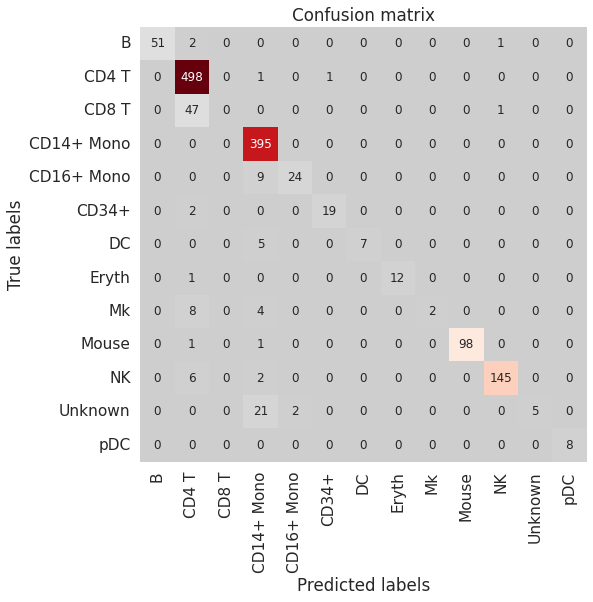

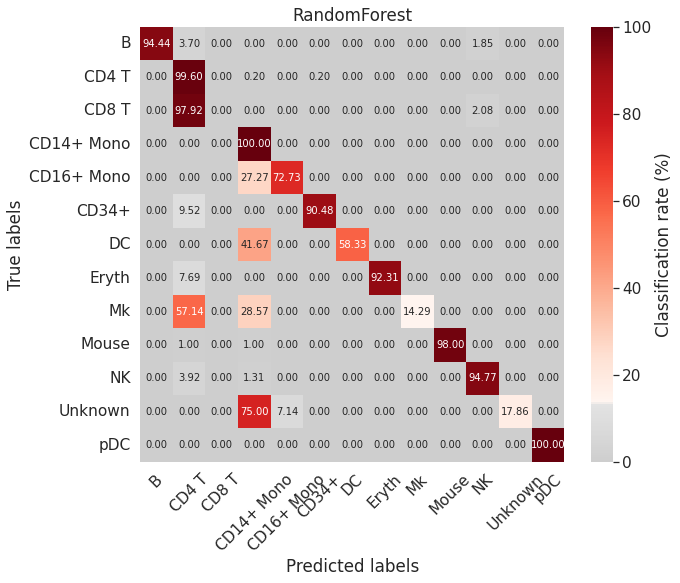

Accuracy: 0.9166062364031907: Misclassification: 0.08339376359680928
              precision    recall  f1-score   support

           B       1.00      0.94      0.97        54
       CD4 T       0.88      1.00      0.94       500
       CD8 T       0.00      0.00      0.00        48
  CD14+ Mono       0.90      1.00      0.95       395
  CD16+ Mono       0.92      0.73      0.81        33
       CD34+       0.95      0.90      0.93        21
          DC       1.00      0.58      0.74        12
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.14      0.25        14
       Mouse       1.00      0.98      0.99       100
          NK       0.99      0.95      0.97       153
     Unknown       1.00      0.18      0.30        28
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

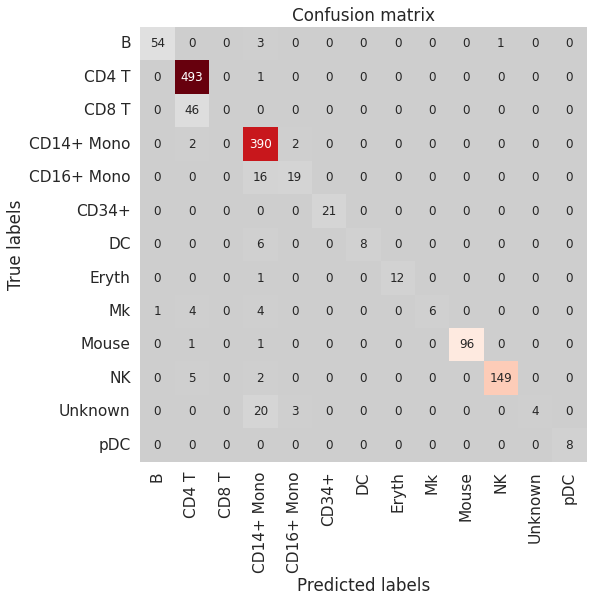

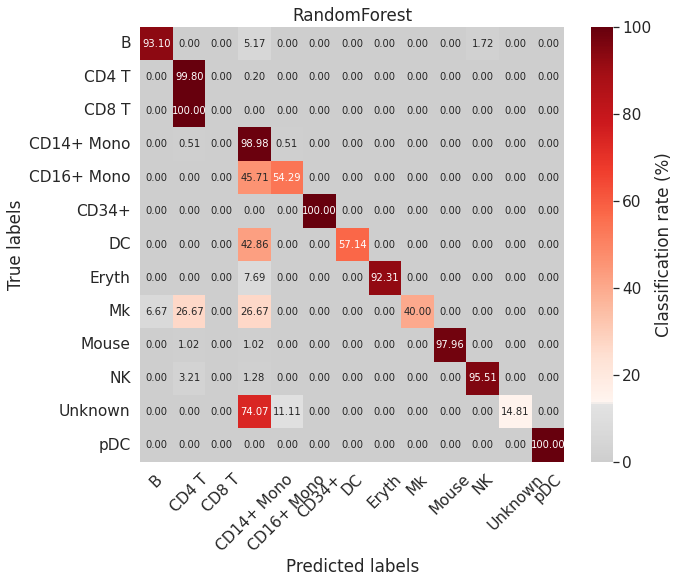

Accuracy: 0.9137055837563451: Misclassification: 0.08629441624365486
              precision    recall  f1-score   support

           B       0.98      0.93      0.96        58
       CD4 T       0.89      1.00      0.94       494
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.88      0.99      0.93       394
  CD16+ Mono       0.79      0.54      0.64        35
       CD34+       1.00      1.00      1.00        21
          DC       1.00      0.57      0.73        14
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.40      0.57        15
       Mouse       1.00      0.98      0.99        98
          NK       0.99      0.96      0.97       156
     Unknown       1.00      0.15      0.26        27
         pDC       1.00      1.00      1.00         8

    accuracy                           0.91      1379
   macro avg       0.89      0.73      0.77      1379
weighted avg       0.89      0.91      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

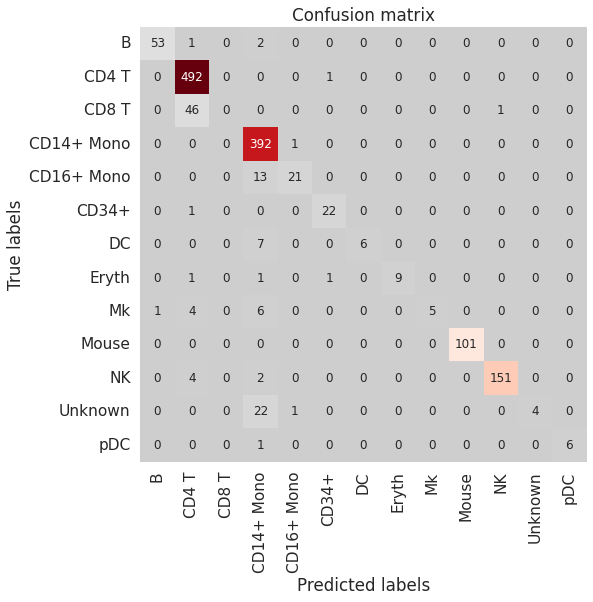

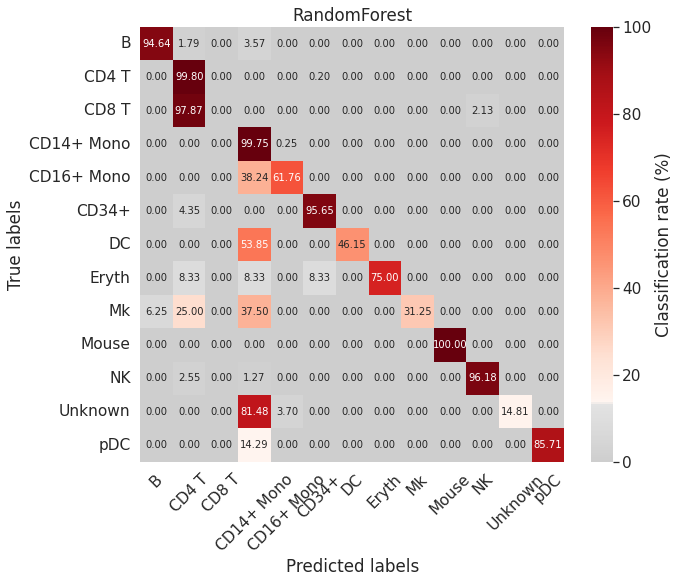

Accuracy: 0.9151559100797679: Misclassification: 0.08484408992023207
              precision    recall  f1-score   support

           B       0.98      0.95      0.96        56
       CD4 T       0.90      1.00      0.94       493
       CD8 T       0.00      0.00      0.00        47
  CD14+ Mono       0.88      1.00      0.93       393
  CD16+ Mono       0.91      0.62      0.74        34
       CD34+       0.92      0.96      0.94        23
          DC       1.00      0.46      0.63        13
       Eryth       1.00      0.75      0.86        12
          Mk       1.00      0.31      0.48        16
       Mouse       1.00      1.00      1.00       101
          NK       0.99      0.96      0.98       157
     Unknown       1.00      0.15      0.26        27
         pDC       1.00      0.86      0.92         7

    accuracy                           0.92      1379
   macro avg       0.89      0.69      0.74      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

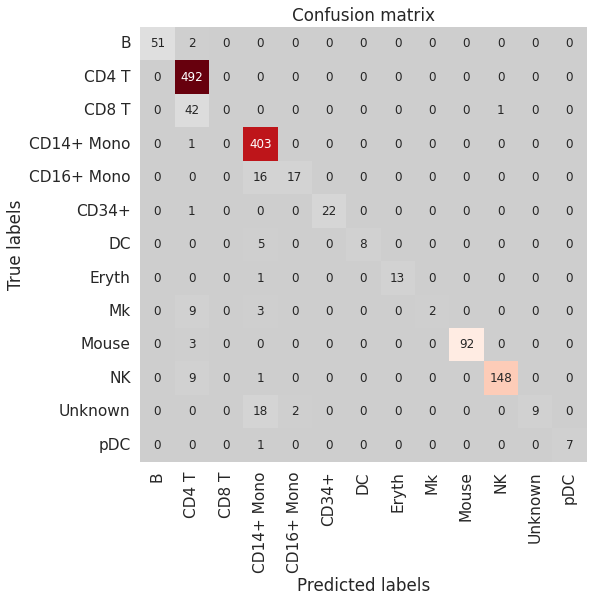

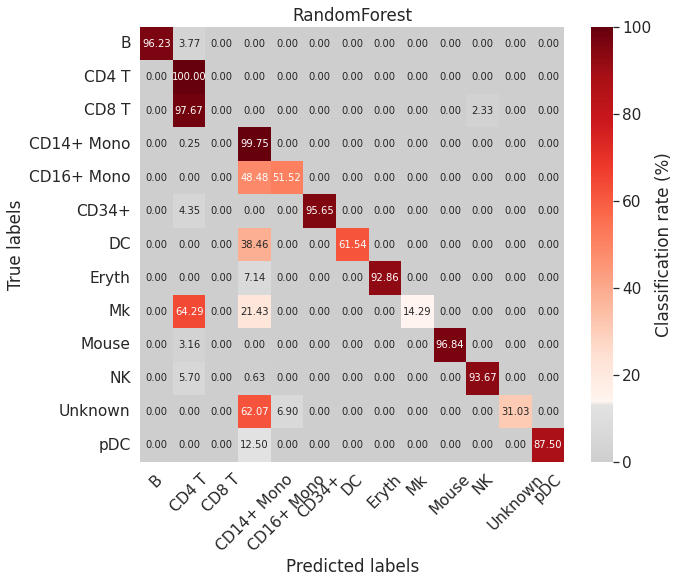

Accuracy: 0.9166062364031907: Misclassification: 0.08339376359680928
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        53
       CD4 T       0.88      1.00      0.94       492
       CD8 T       0.00      0.00      0.00        43
  CD14+ Mono       0.90      1.00      0.95       404
  CD16+ Mono       0.89      0.52      0.65        33
       CD34+       1.00      0.96      0.98        23
          DC       1.00      0.62      0.76        13
       Eryth       1.00      0.93      0.96        14
          Mk       1.00      0.14      0.25        14
       Mouse       1.00      0.97      0.98        95
          NK       0.99      0.94      0.96       158
     Unknown       1.00      0.31      0.47        29
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.90      0.71      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

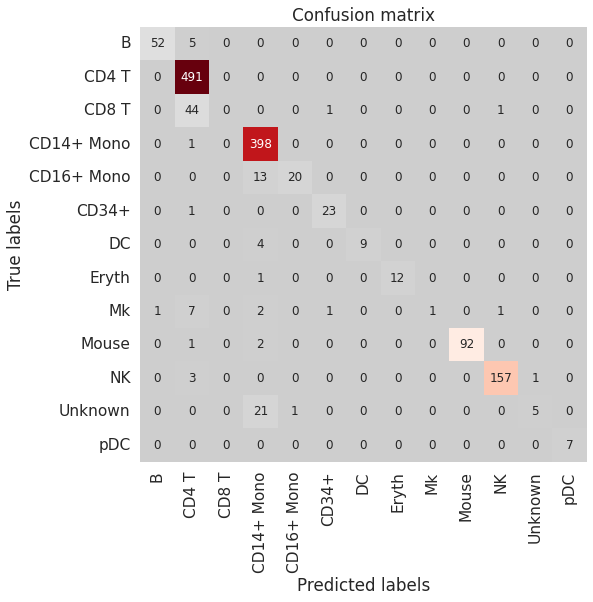

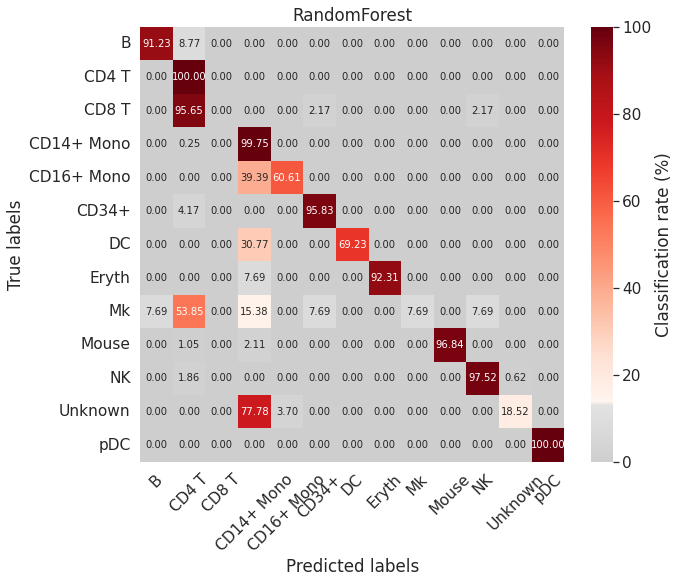

Accuracy: 0.9187817258883249: Misclassification: 0.08121827411167515
              precision    recall  f1-score   support

           B       0.98      0.91      0.95        57
       CD4 T       0.89      1.00      0.94       491
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.90      1.00      0.95       399
  CD16+ Mono       0.95      0.61      0.74        33
       CD34+       0.92      0.96      0.94        24
          DC       1.00      0.69      0.82        13
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.08      0.14        13
       Mouse       1.00      0.97      0.98        95
          NK       0.99      0.98      0.98       161
     Unknown       0.83      0.19      0.30        27
         pDC       1.00      1.00      1.00         7

    accuracy                           0.92      1379
   macro avg       0.88      0.72      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 3min 58s, sys: 4.53 s, total: 4min 2s
Wall time: 1min 55s


In [16]:
%%time
for k in k_range:
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_k_{}.png'.format(k), markers = smash_markers)

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

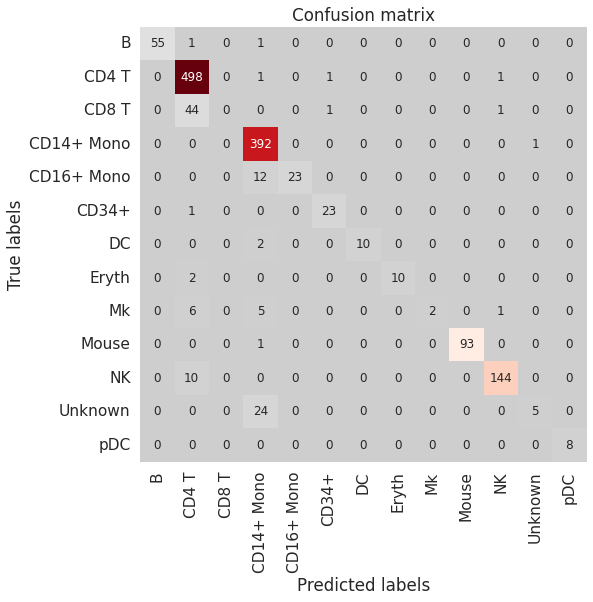

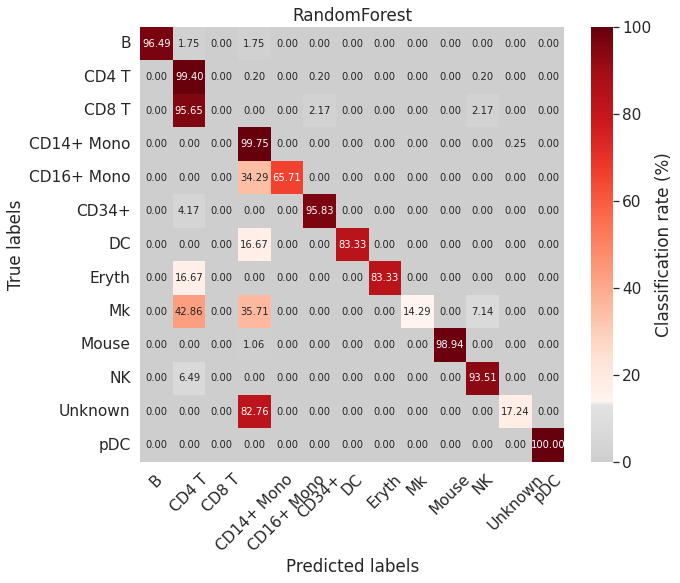

Accuracy: 0.9158810732414794: Misclassification: 0.08411892675852062
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        57
       CD4 T       0.89      0.99      0.94       501
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.89      1.00      0.94       393
  CD16+ Mono       1.00      0.66      0.79        35
       CD34+       0.92      0.96      0.94        24
          DC       1.00      0.83      0.91        12
       Eryth       1.00      0.83      0.91        12
          Mk       1.00      0.14      0.25        14
       Mouse       1.00      0.99      0.99        94
          NK       0.98      0.94      0.96       154
     Unknown       0.83      0.17      0.29        29
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.89      0.73      0.76      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

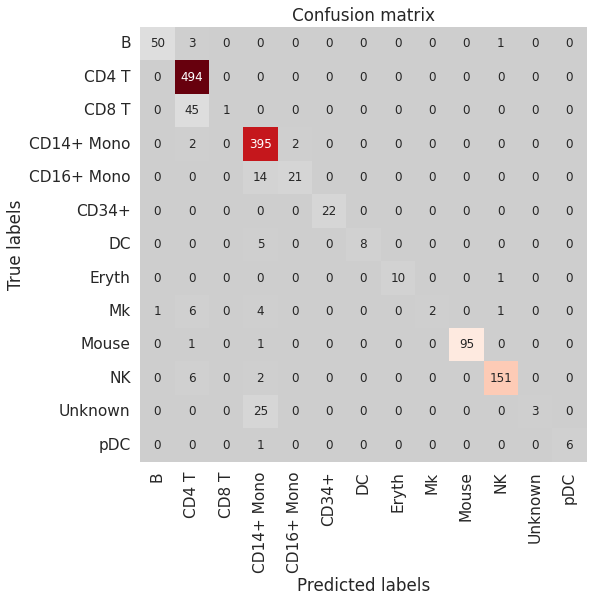

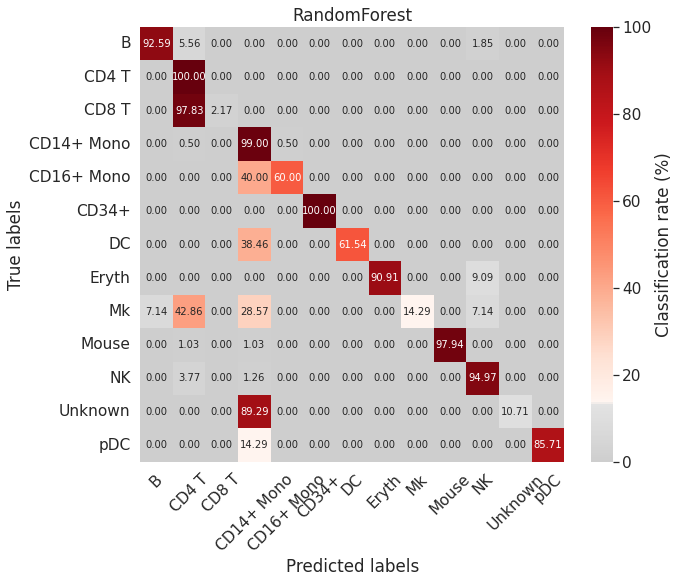

Accuracy: 0.9122552574329225: Misclassification: 0.08774474256707754
              precision    recall  f1-score   support

           B       0.98      0.93      0.95        54
       CD4 T       0.89      1.00      0.94       494
       CD8 T       1.00      0.02      0.04        46
  CD14+ Mono       0.88      0.99      0.93       399
  CD16+ Mono       0.91      0.60      0.72        35
       CD34+       1.00      1.00      1.00        22
          DC       1.00      0.62      0.76        13
       Eryth       1.00      0.91      0.95        11
          Mk       1.00      0.14      0.25        14
       Mouse       1.00      0.98      0.99        97
          NK       0.98      0.95      0.96       159
     Unknown       1.00      0.11      0.19        28
         pDC       1.00      0.86      0.92         7

    accuracy                           0.91      1379
   macro avg       0.97      0.70      0.74      1379
weighted avg       0.92      0.91      0.89      1379

 * Initial

<Figure size 432x288 with 0 Axes>

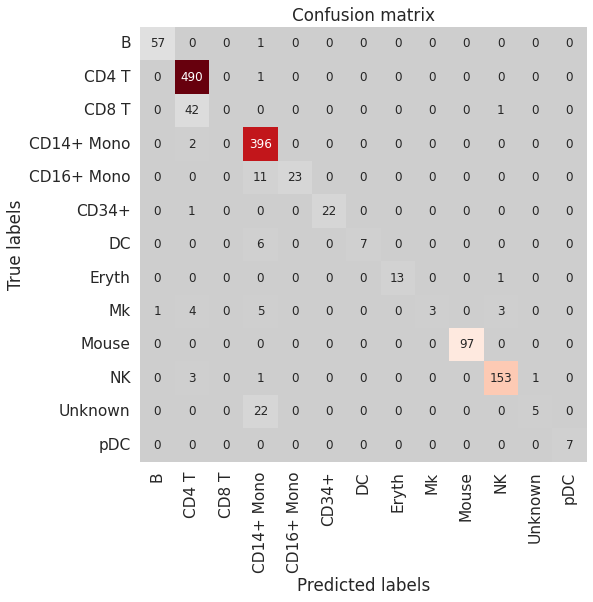

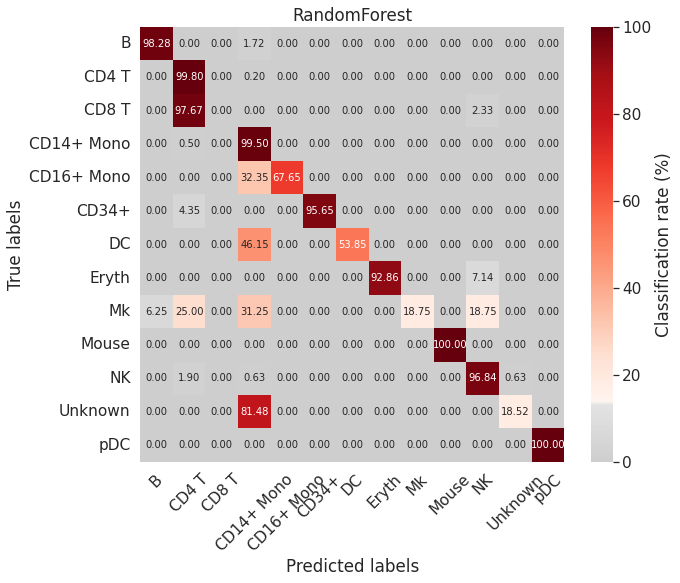

Accuracy: 0.9231327048585932: Misclassification: 0.07686729514140678
              precision    recall  f1-score   support

           B       0.98      0.98      0.98        58
       CD4 T       0.90      1.00      0.95       491
       CD8 T       0.00      0.00      0.00        43
  CD14+ Mono       0.89      0.99      0.94       398
  CD16+ Mono       1.00      0.68      0.81        34
       CD34+       1.00      0.96      0.98        23
          DC       1.00      0.54      0.70        13
       Eryth       1.00      0.93      0.96        14
          Mk       1.00      0.19      0.32        16
       Mouse       1.00      1.00      1.00        97
          NK       0.97      0.97      0.97       158
     Unknown       0.83      0.19      0.30        27
         pDC       1.00      1.00      1.00         7

    accuracy                           0.92      1379
   macro avg       0.89      0.72      0.76      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

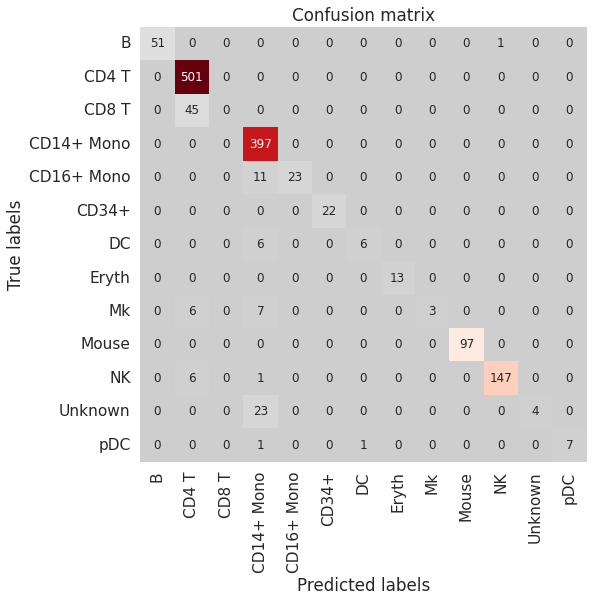

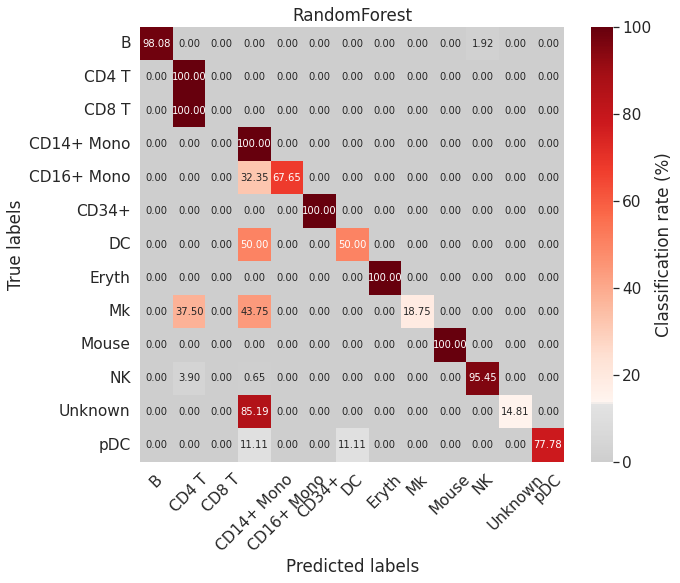

Accuracy: 0.9216823785351704: Misclassification: 0.07831762146482957
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        52
       CD4 T       0.90      1.00      0.95       501
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.89      1.00      0.94       397
  CD16+ Mono       1.00      0.68      0.81        34
       CD34+       1.00      1.00      1.00        22
          DC       0.86      0.50      0.63        12
       Eryth       1.00      1.00      1.00        13
          Mk       1.00      0.19      0.32        16
       Mouse       1.00      1.00      1.00        97
          NK       0.99      0.95      0.97       154
     Unknown       1.00      0.15      0.26        27
         pDC       1.00      0.78      0.88         9

    accuracy                           0.92      1379
   macro avg       0.90      0.71      0.75      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

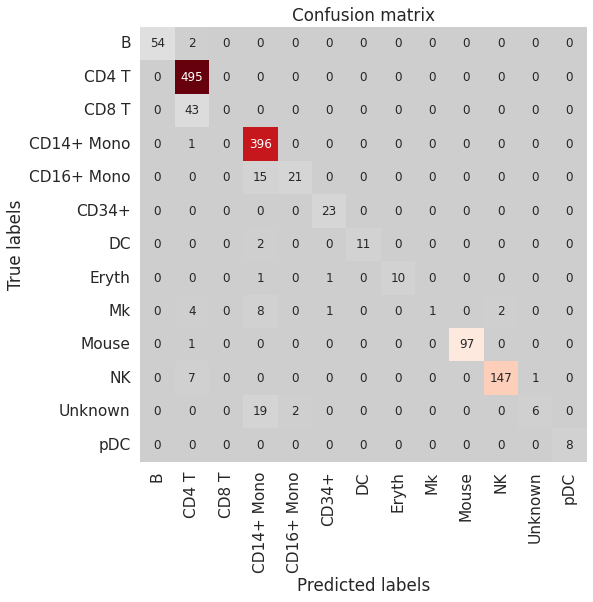

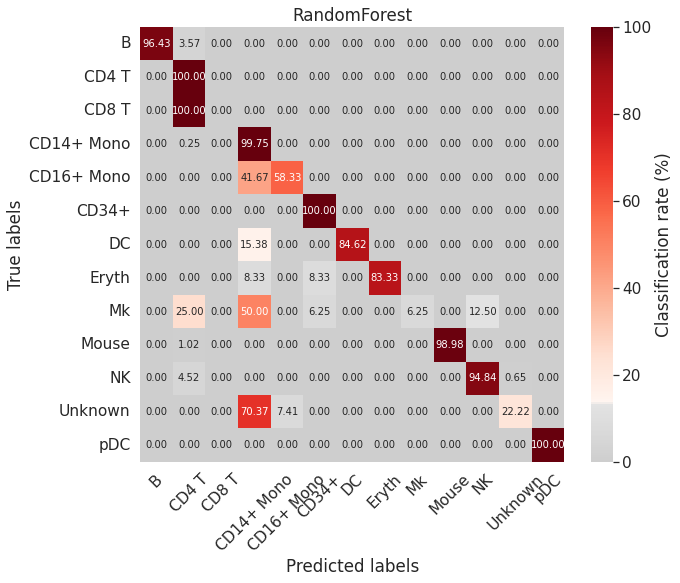

Accuracy: 0.9202320522117476: Misclassification: 0.07976794778825236
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        56
       CD4 T       0.90      1.00      0.94       495
       CD8 T       0.00      0.00      0.00        43
  CD14+ Mono       0.90      1.00      0.95       397
  CD16+ Mono       0.91      0.58      0.71        36
       CD34+       0.92      1.00      0.96        23
          DC       1.00      0.85      0.92        13
       Eryth       1.00      0.83      0.91        12
          Mk       1.00      0.06      0.12        16
       Mouse       1.00      0.99      0.99        98
          NK       0.99      0.95      0.97       155
     Unknown       0.86      0.22      0.35        27
         pDC       1.00      1.00      1.00         8

    accuracy                           0.92      1379
   macro avg       0.88      0.73      0.75      1379
weighted avg       0.89      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

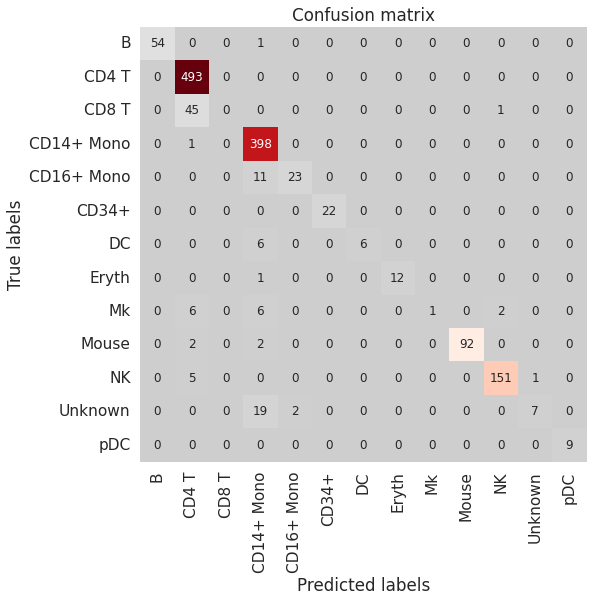

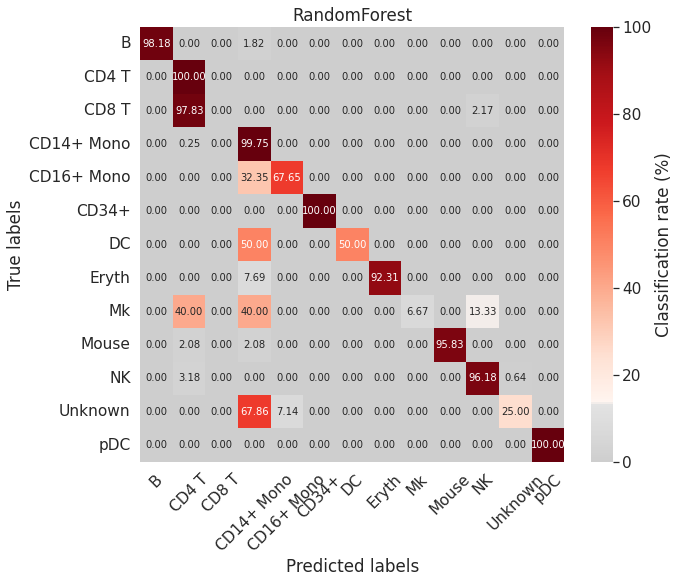

Accuracy: 0.9195068890500363: Misclassification: 0.0804931109499637
              precision    recall  f1-score   support

           B       1.00      0.98      0.99        55
       CD4 T       0.89      1.00      0.94       493
       CD8 T       0.00      0.00      0.00        46
  CD14+ Mono       0.90      1.00      0.94       399
  CD16+ Mono       0.92      0.68      0.78        34
       CD34+       1.00      1.00      1.00        22
          DC       1.00      0.50      0.67        12
       Eryth       1.00      0.92      0.96        13
          Mk       1.00      0.07      0.12        15
       Mouse       1.00      0.96      0.98        96
          NK       0.98      0.96      0.97       157
     Unknown       0.88      0.25      0.39        28
         pDC       1.00      1.00      1.00         9

    accuracy                           0.92      1379
   macro avg       0.89      0.72      0.75      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

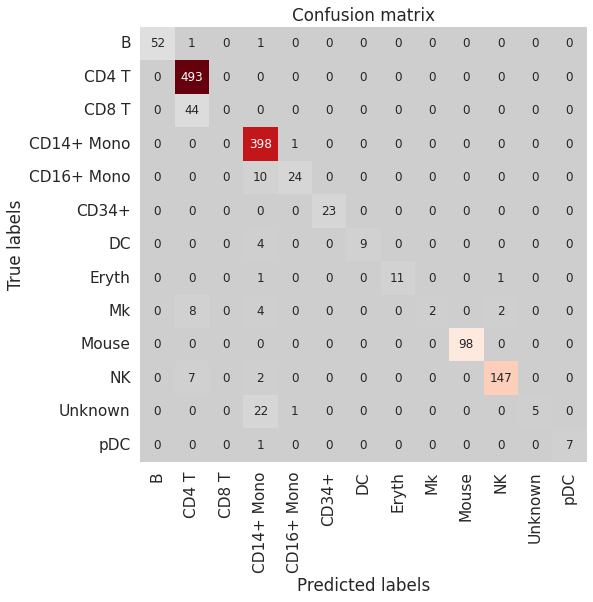

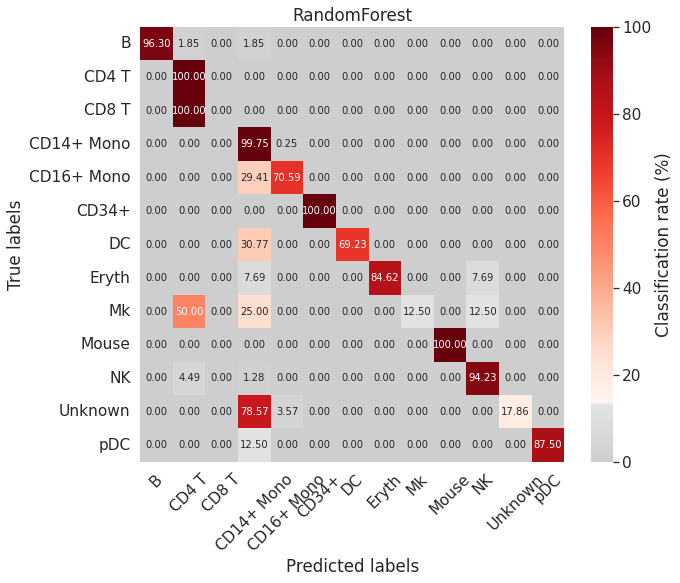

Accuracy: 0.9202320522117476: Misclassification: 0.07976794778825236
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        54
       CD4 T       0.89      1.00      0.94       493
       CD8 T       0.00      0.00      0.00        44
  CD14+ Mono       0.90      1.00      0.95       399
  CD16+ Mono       0.92      0.71      0.80        34
       CD34+       1.00      1.00      1.00        23
          DC       1.00      0.69      0.82        13
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.12      0.22        16
       Mouse       1.00      1.00      1.00        98
          NK       0.98      0.94      0.96       156
     Unknown       1.00      0.18      0.30        28
         pDC       1.00      0.88      0.93         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.76      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

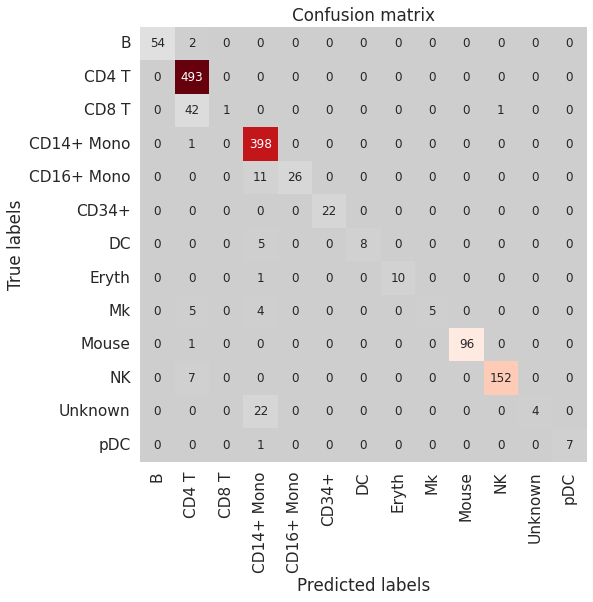

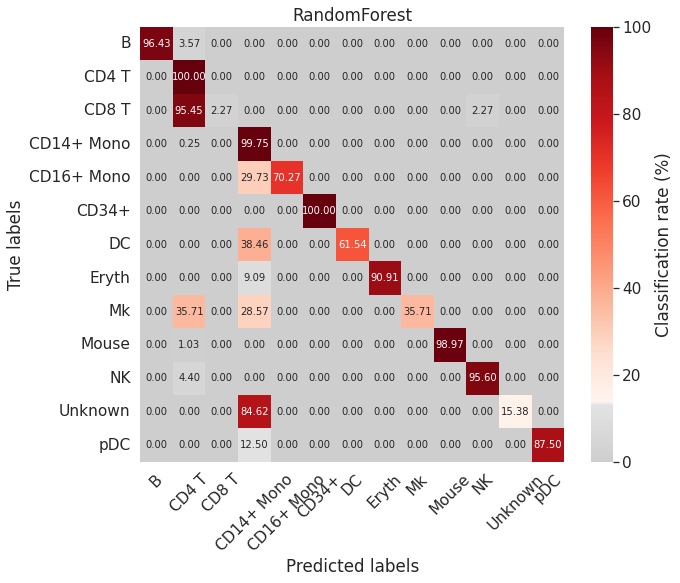

Accuracy: 0.9253081943437274: Misclassification: 0.07469180565627265
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        56
       CD4 T       0.89      1.00      0.94       493
       CD8 T       1.00      0.02      0.04        44
  CD14+ Mono       0.90      1.00      0.95       399
  CD16+ Mono       1.00      0.70      0.83        37
       CD34+       1.00      1.00      1.00        22
          DC       1.00      0.62      0.76        13
       Eryth       1.00      0.91      0.95        11
          Mk       1.00      0.36      0.53        14
       Mouse       1.00      0.99      0.99        97
          NK       0.99      0.96      0.97       159
     Unknown       1.00      0.15      0.27        26
         pDC       1.00      0.88      0.93         8

    accuracy                           0.93      1379
   macro avg       0.98      0.73      0.78      1379
weighted avg       0.93      0.93      0.90      1379

 * Initial

<Figure size 432x288 with 0 Axes>

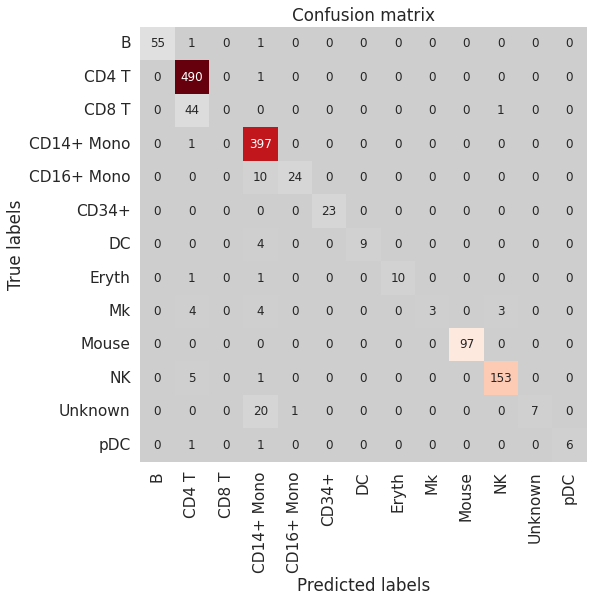

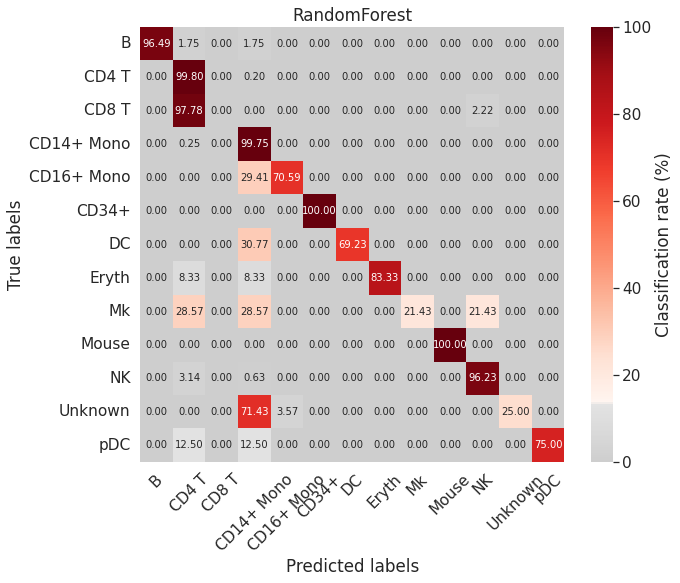

Accuracy: 0.9238578680203046: Misclassification: 0.07614213197969544
              precision    recall  f1-score   support

           B       1.00      0.96      0.98        57
       CD4 T       0.90      1.00      0.94       491
       CD8 T       0.00      0.00      0.00        45
  CD14+ Mono       0.90      1.00      0.95       398
  CD16+ Mono       0.96      0.71      0.81        34
       CD34+       1.00      1.00      1.00        23
          DC       1.00      0.69      0.82        13
       Eryth       1.00      0.83      0.91        12
          Mk       1.00      0.21      0.35        14
       Mouse       1.00      1.00      1.00        97
          NK       0.97      0.96      0.97       159
     Unknown       1.00      0.25      0.40        28
         pDC       1.00      0.75      0.86         8

    accuracy                           0.92      1379
   macro avg       0.90      0.72      0.77      1379
weighted avg       0.90      0.92      0.90      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

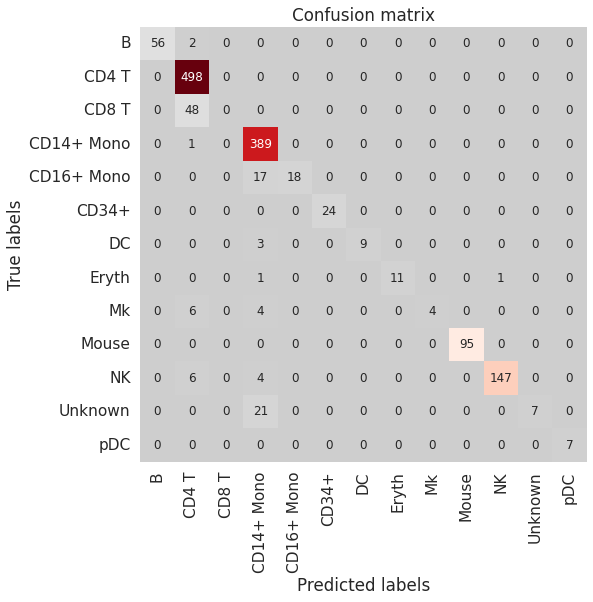

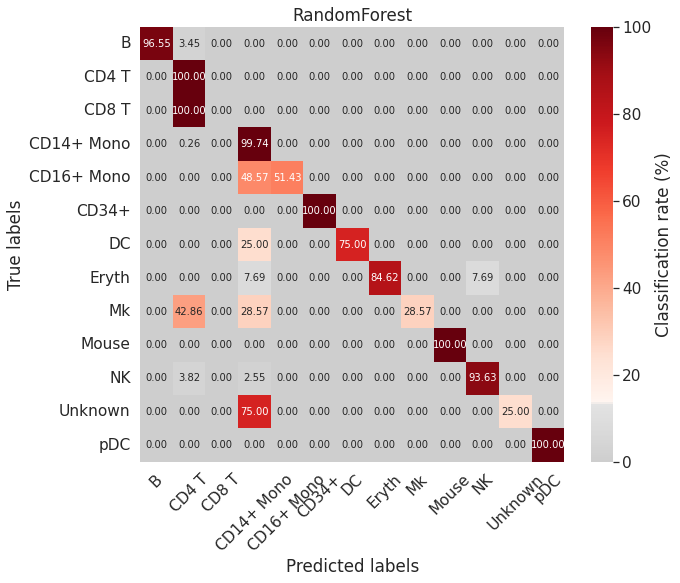

Accuracy: 0.9173313995649021: Misclassification: 0.08266860043509794
              precision    recall  f1-score   support

           B       1.00      0.97      0.98        58
       CD4 T       0.89      1.00      0.94       498
       CD8 T       0.00      0.00      0.00        48
  CD14+ Mono       0.89      1.00      0.94       390
  CD16+ Mono       1.00      0.51      0.68        35
       CD34+       1.00      1.00      1.00        24
          DC       1.00      0.75      0.86        12
       Eryth       1.00      0.85      0.92        13
          Mk       1.00      0.29      0.44        14
       Mouse       1.00      1.00      1.00        95
          NK       0.99      0.94      0.96       157
     Unknown       1.00      0.25      0.40        28
         pDC       1.00      1.00      1.00         7

    accuracy                           0.92      1379
   macro avg       0.91      0.73      0.78      1379
weighted avg       0.89      0.92      0.89      1379



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 7min 44s, sys: 9.08 s, total: 7min 53s
Wall time: 3min 42s


In [17]:
%%time
k = 50
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                16032     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

69/69 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.7537 - auc: 0.9817 - precision: 0.9247 - recall: 0.3972 - val_loss: 0.6936 - val_accuracy: 0.8683 - val_auc: 0.9937 - val_precision: 0.9610 - val_recall: 0.5145

Epoch 00018: val_loss improved from 0.76736 to 0.69364, saving model to weights/best_model_annotation.h5
Epoch 19/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2241 - accuracy: 0.8984 - auc: 0.9962 - precision: 0.9310 - recall: 0.8477 - val_loss: 0.2626 - val_accuracy: 0.9240 - val_auc: 0.9972 - val_precision: 0.9354 - val_recall: 0.9066

Epoch 00042: val_loss improved from 0.26873 to 0.26261, saving model to weights/best_model_annotation.h5
Epoch 43/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_m

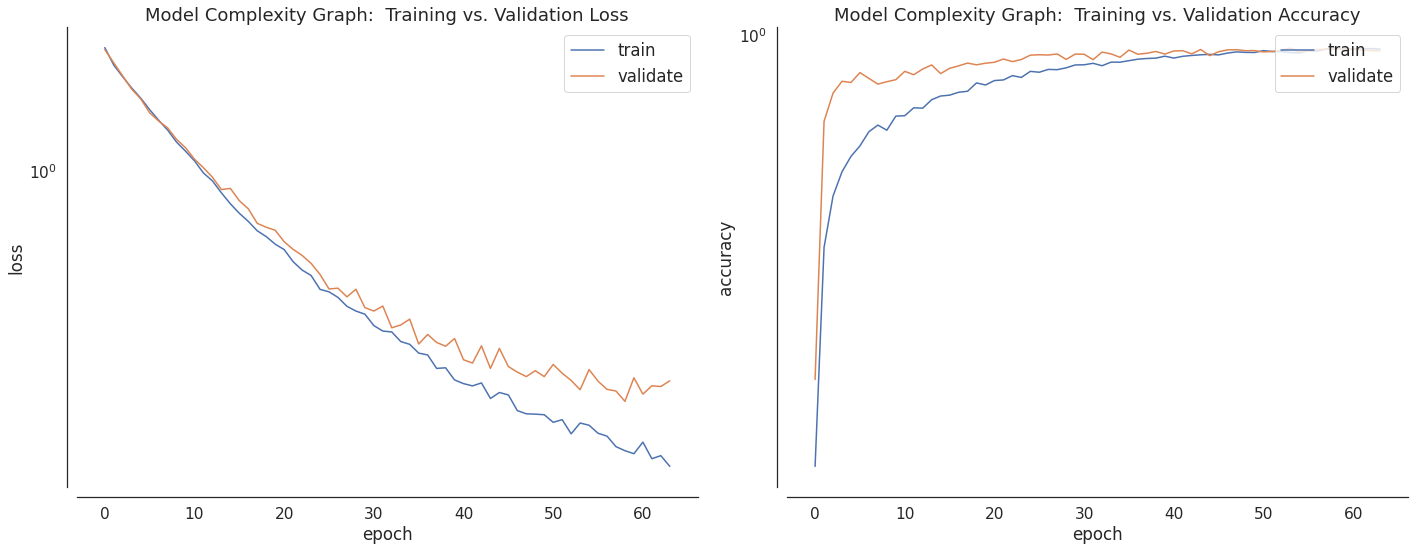

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

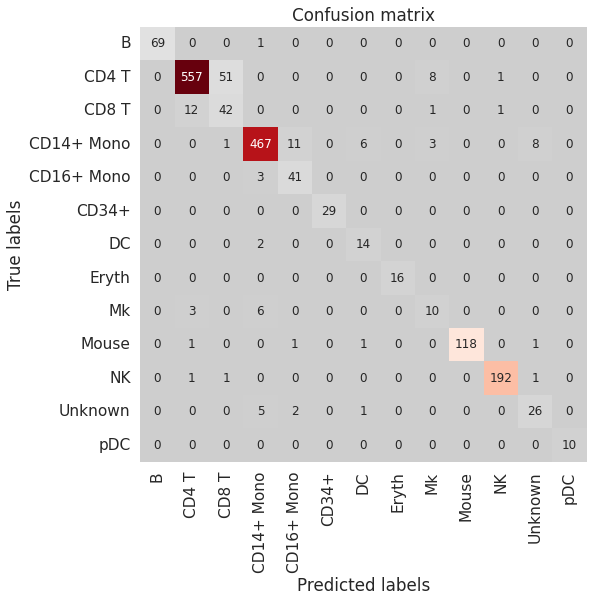

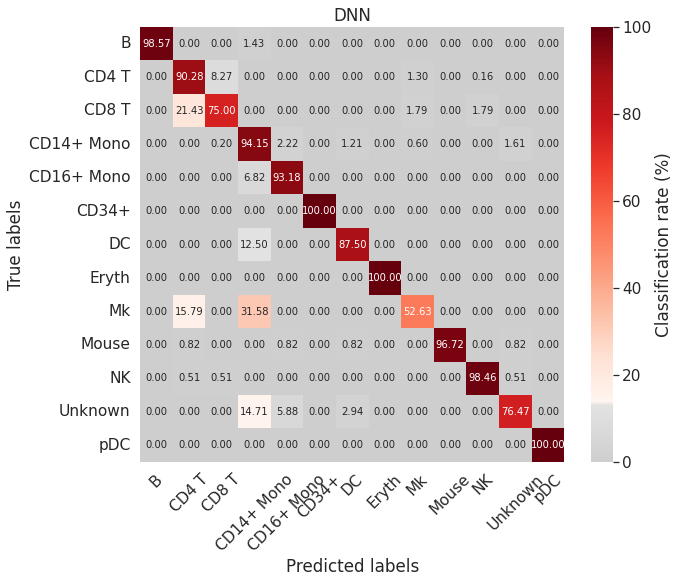

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


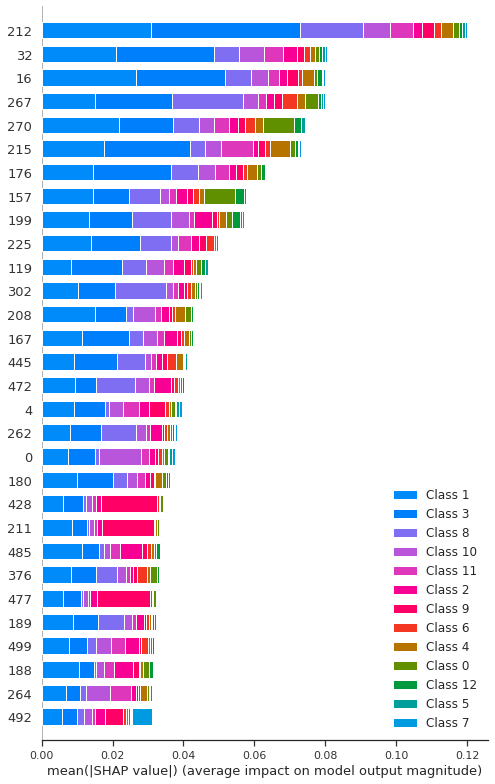

 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                16032     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

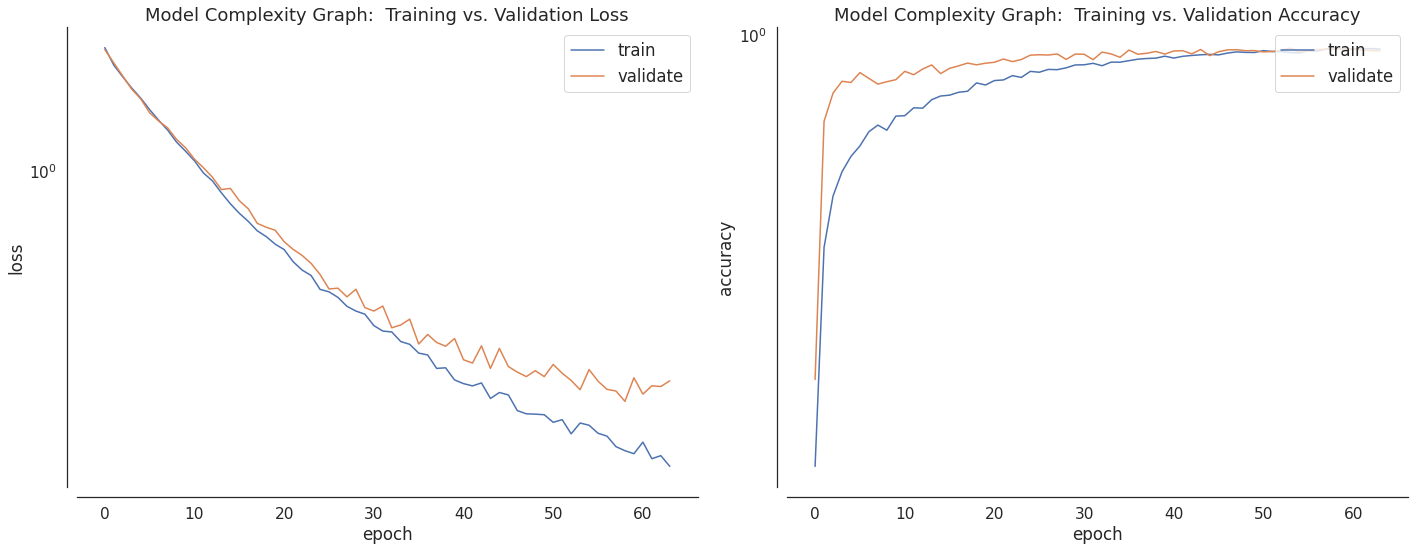

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

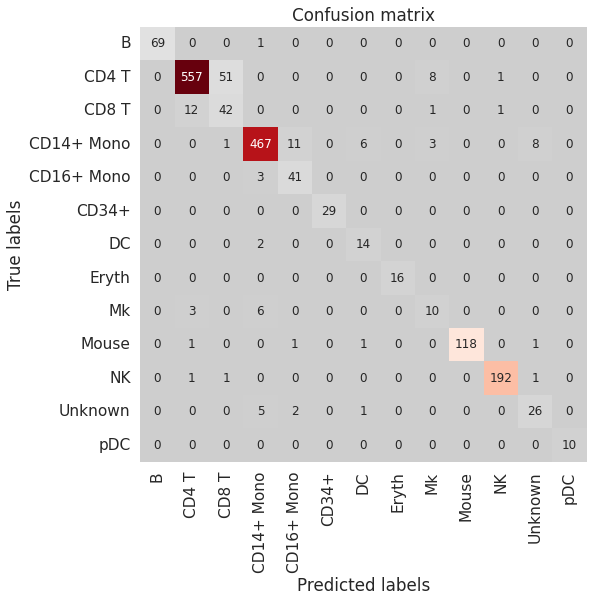

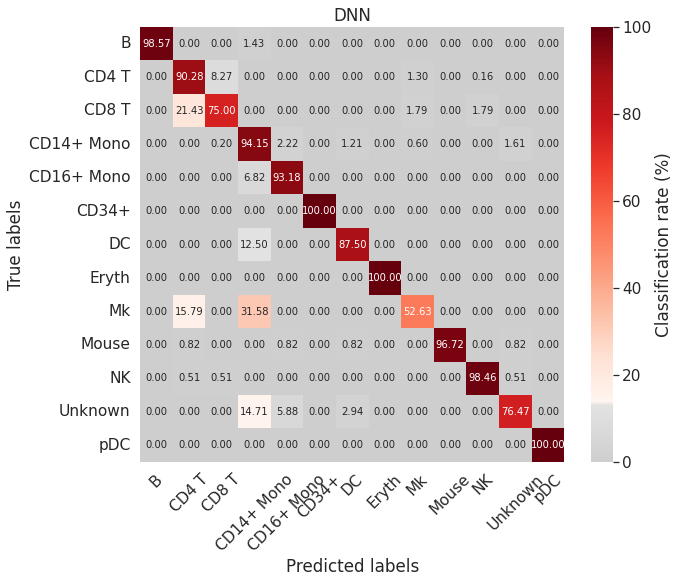

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


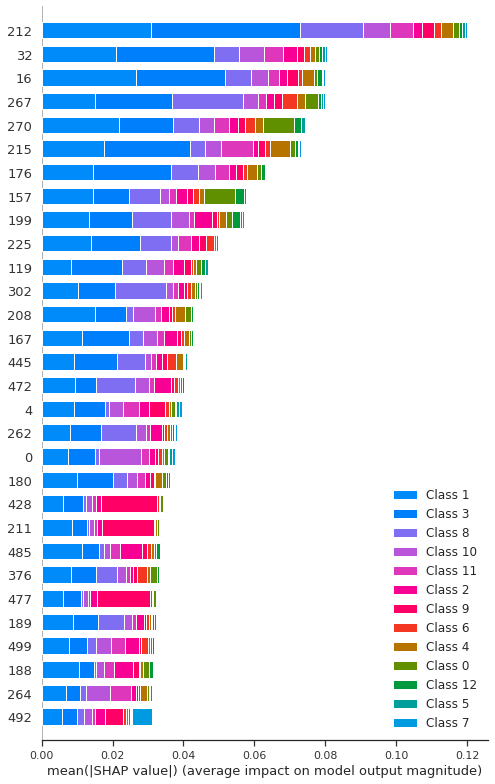

 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

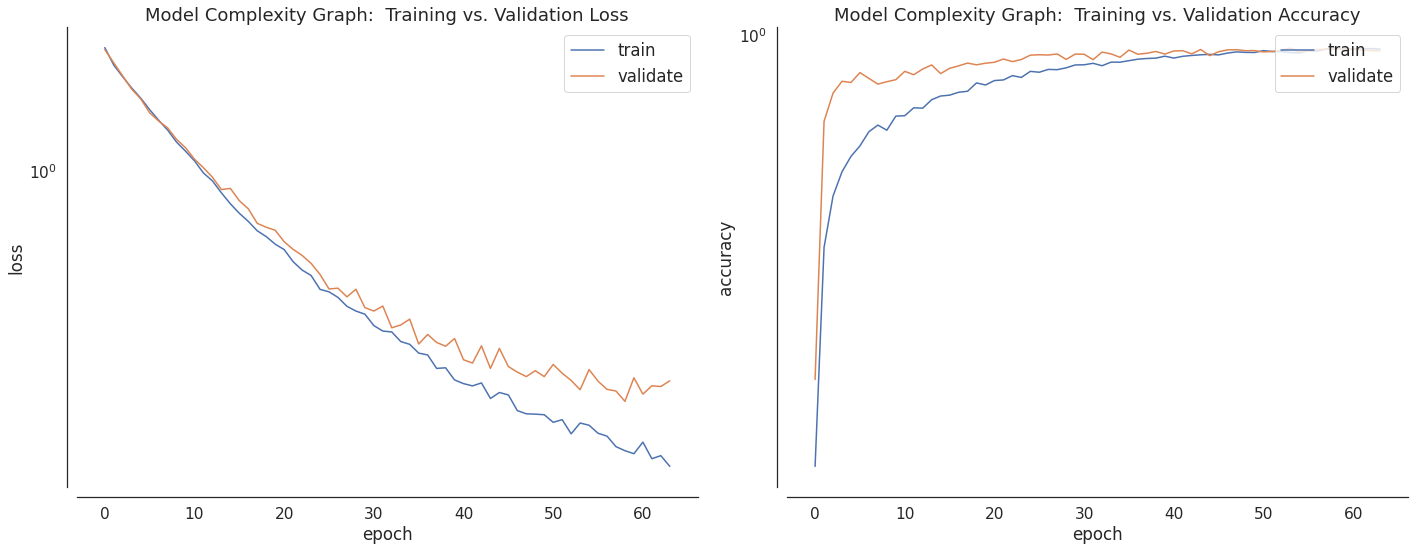

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

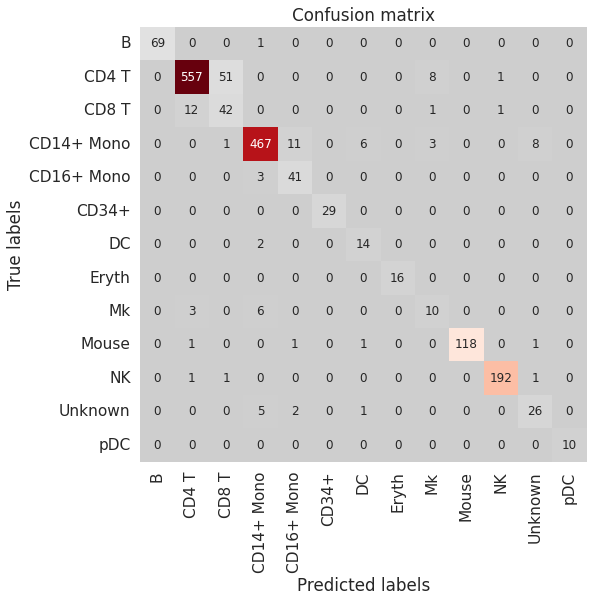

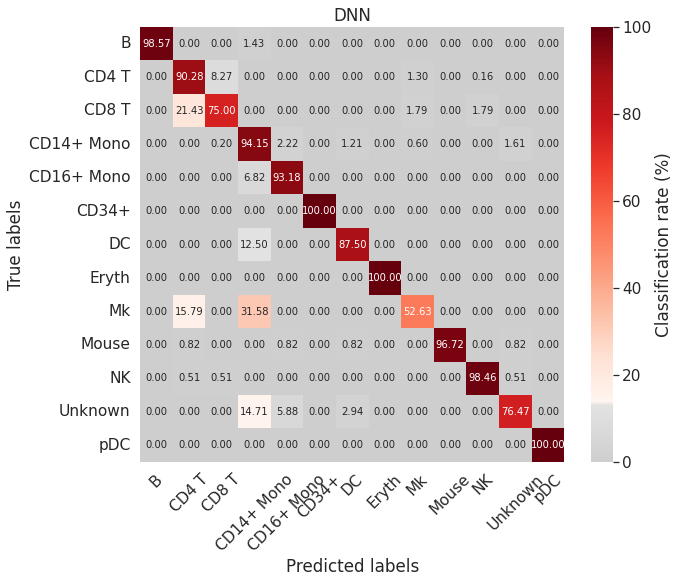

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


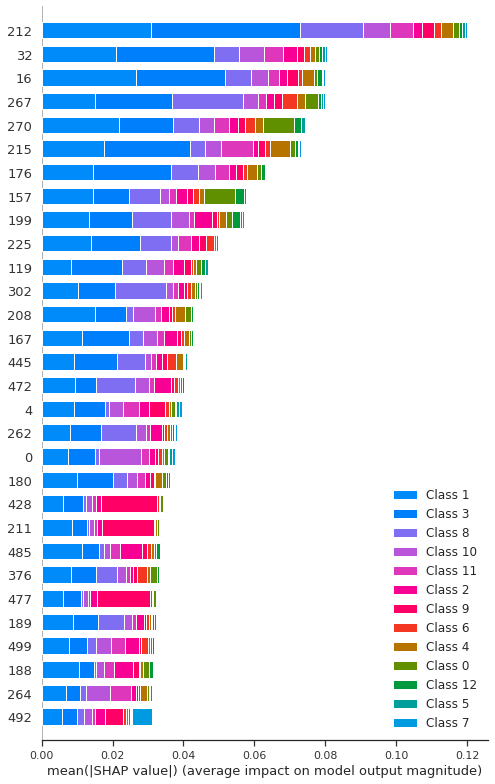

 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

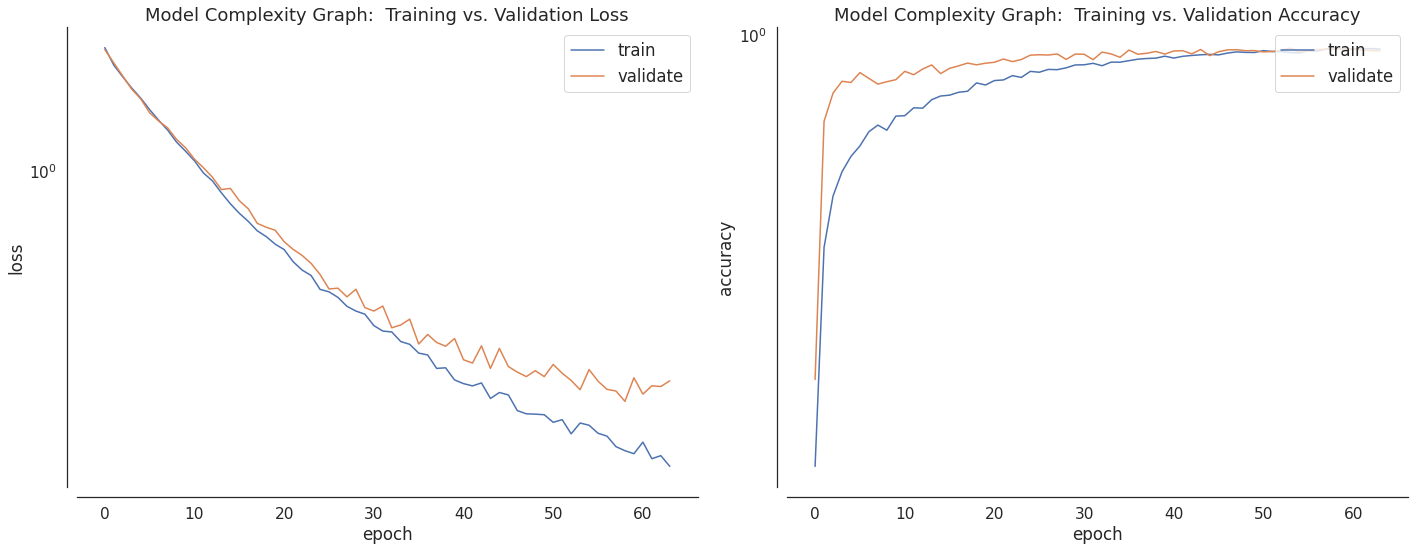

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

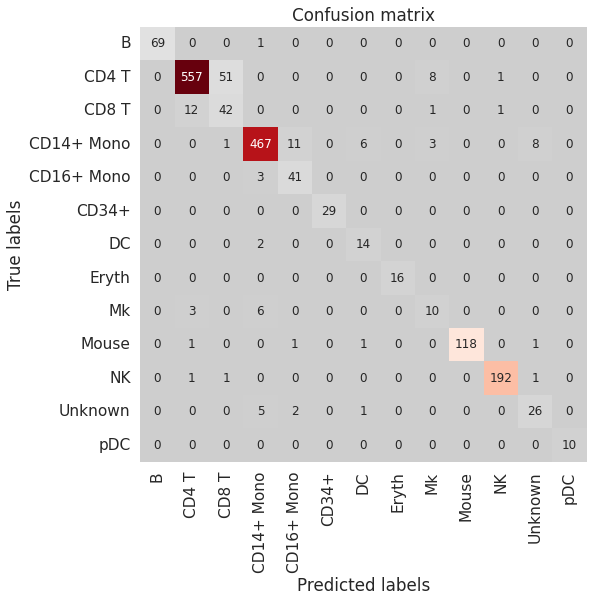

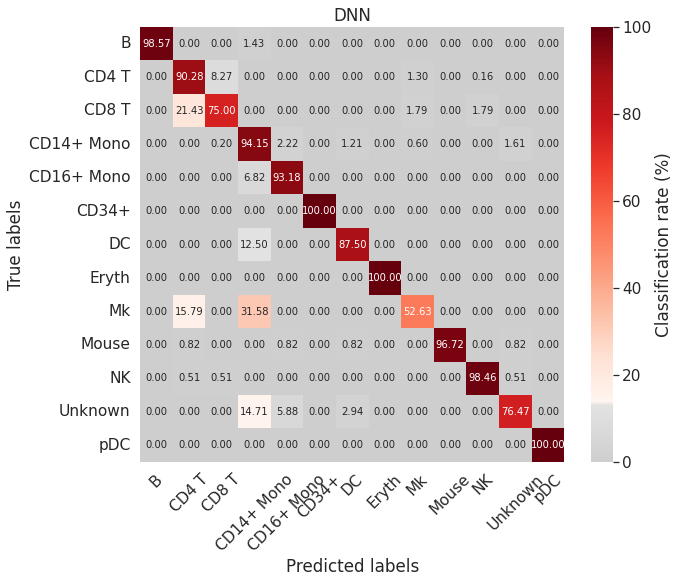

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


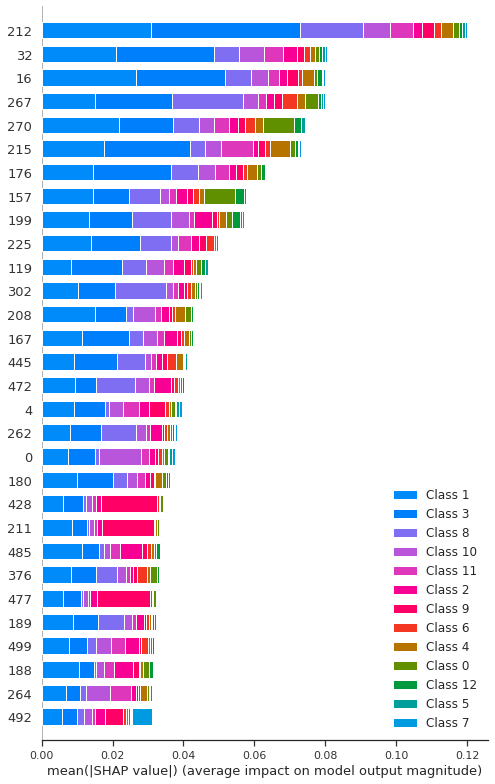

 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

69/69 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.7859 - auc: 0.9846 - precision: 0.9252 - recall: 0.4503 - val_loss: 0.6750 - val_accuracy: 0.8608 - val_auc: 0.9932 - val_precision: 0.9591 - val_recall: 0.5708

Epoch 00019: val_loss improved from 0.69364 to 0.67500, saving model to weights/best_model_annotation.h5
Epoch 20/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7777 - auc: 0.9844 - precision: 0.9239 - recall: 0.4806 - val_loss: 0.6611 - val_accuracy: 0.8677 - val_auc: 0.9934 - val_precision: 0.9495 - val_recall: 0.5783

Epoch 00020: val_loss improved from 0.67500 to 0.66111, saving model to weights/best_model_annotation.h5
Epoch 21/100
69/69 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7953 - auc: 0.9866 - precision: 0.9256 - recall: 0.5217 - val_loss: 0.6105 - val_accuracy: 0.8718 - val_auc: 0.9940 - val_precision: 0.9520 - val_recall: 0.6439

Epoch 00021: val_loss improved f

69/69 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9022 - auc: 0.9963 - precision: 0.9357 - recall: 0.8532 - val_loss: 0.2960 - val_accuracy: 0.9095 - val_auc: 0.9966 - val_precision: 0.9237 - val_recall: 0.8852

Epoch 00043: val_loss did not improve from 0.26261
Epoch 44/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9053 - auc: 0.9965 - precision: 0.9386 - recall: 0.8567 - val_loss: 0.2530 - val_accuracy: 0.9298 - val_auc: 0.9973 - val_precision: 0.9402 - val_recall: 0.9113

Epoch 00044: val_loss improved from 0.26261 to 0.25305, saving model to weights/best_model_annotation.h5
Epoch 45/100
69/69 [==============================] - 0s 3ms/step - loss: 0.2140 - accuracy: 0.9072 - auc: 0.9966 - precision: 0.9366 - recall: 0.8580 - val_loss: 0.2908 - val_accuracy: 0.9014 - val_auc: 0.9965 - val_precision: 0.9117 - val_recall: 0.8869

Epoch 00045: val_loss did not improve from 0.25305
Epoch 46/100
69/69 [===============

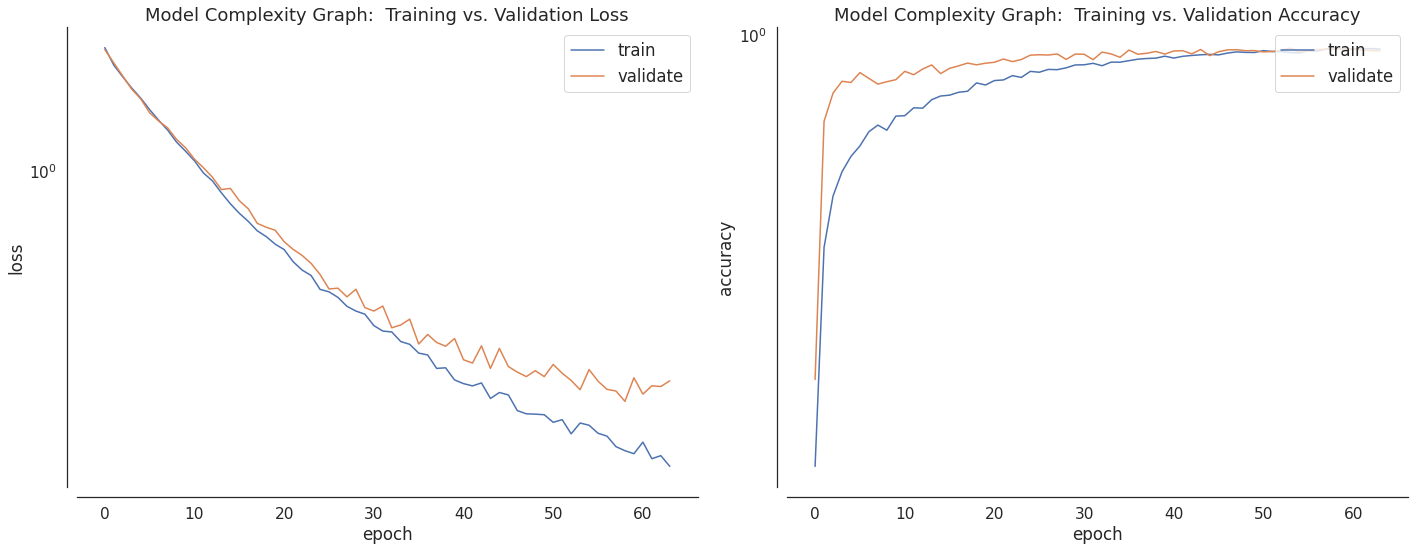

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

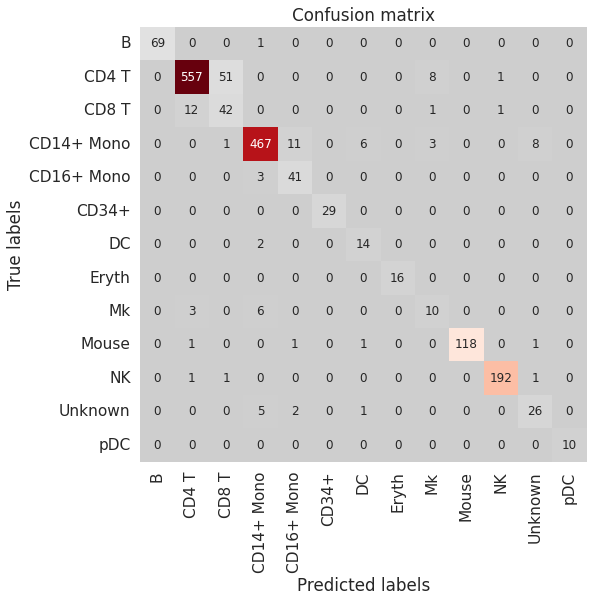

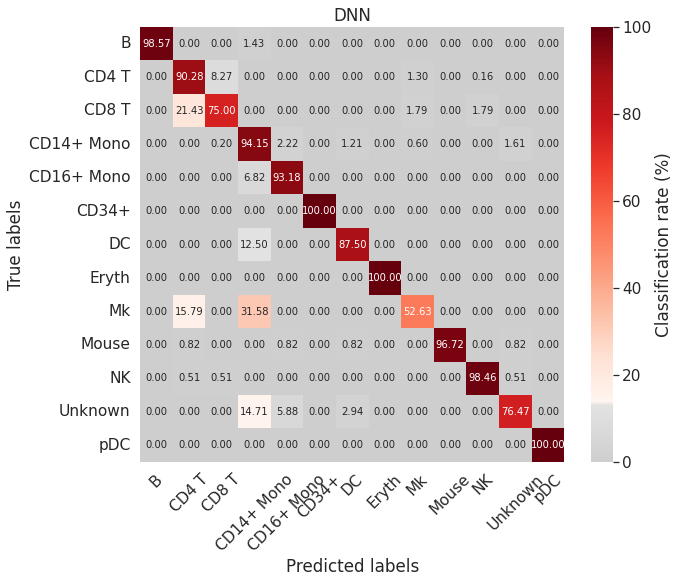

              precision    recall  f1-score   support

           B       1.00      0.99      0.99        70
       CD4 T       0.97      0.90      0.94       617
       CD8 T       0.44      0.75      0.56        56
  CD14+ Mono       0.96      0.94      0.95       496
  CD16+ Mono       0.75      0.93      0.83        44
       CD34+       1.00      1.00      1.00        29
          DC       0.64      0.88      0.74        16
       Eryth       1.00      1.00      1.00        16
          Mk       0.45      0.53      0.49        19
       Mouse       1.00      0.97      0.98       122
          NK       0.99      0.98      0.99       195
     Unknown       0.72      0.76      0.74        34
         pDC       1.00      1.00      1.00        10

    accuracy                           0.92      1724
   macro avg       0.84      0.89      0.86      1724
weighted avg       0.94      0.92      0.93      1724

54/54 [==============================] - 0s 1ms/step - loss: 0.2013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


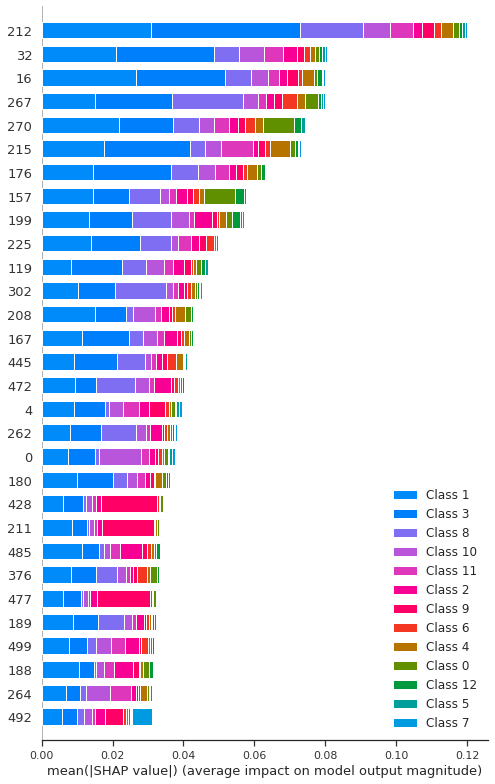

CPU times: user 7min 23s, sys: 14.4 s, total: 7min 38s
Wall time: 3min 38s


In [18]:
%%time
for k in k_range:
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(citeseq_adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(citeseq_adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'smash_markers_k_{}.npy'.format(k), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_k_{}.png'.format(k), markers = smash_markers)

 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7823 - accuracy: 0.7470 - auc: 0.9797 - precision: 0.9472 - recall: 0.3023 - val_loss: 0.8763 - val_accuracy: 0.8477 - val_auc: 0.9894 - val_precision: 0.9688 - val_recall: 0.3372

Epoch 00019: val_loss improved from 0.89991 to 0.87628, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7313 - accuracy: 0.7445 - auc: 0.9800 - precision: 0.9521 - recall: 0.3351 - val_loss: 0.8174 - val_accuracy: 0.8477 - val_auc: 0.9899 - val_precision: 0.9603 - val_recall: 0.4039

Epoch 00020: val_loss improved from 0.87628 to 0.81735, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.7586 - auc: 0.9815 - precision: 0.9425 - recall: 0.3629 - val_loss: 0.7829 - val_accuracy: 0.8608 - val_auc: 0.9905 - val_precision: 0.9495 - val_recall: 0.4228

Epoch 00021: val_loss improved f


Epoch 00042: val_loss improved from 0.36624 to 0.36587, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2901 - accuracy: 0.8868 - auc: 0.9951 - precision: 0.9335 - recall: 0.7969 - val_loss: 0.3405 - val_accuracy: 0.9166 - val_auc: 0.9952 - val_precision: 0.9312 - val_recall: 0.8738

Epoch 00043: val_loss improved from 0.36587 to 0.34048, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2652 - accuracy: 0.8926 - auc: 0.9959 - precision: 0.9413 - recall: 0.8148 - val_loss: 0.3326 - val_accuracy: 0.9101 - val_auc: 0.9952 - val_precision: 0.9292 - val_recall: 0.8753

Epoch 00044: val_loss improved from 0.34048 to 0.33262, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2591 - accuracy: 0.8975 - auc: 0.9961 - precision: 0.9431 - recall: 0.8237 - val_loss: 0.3765 

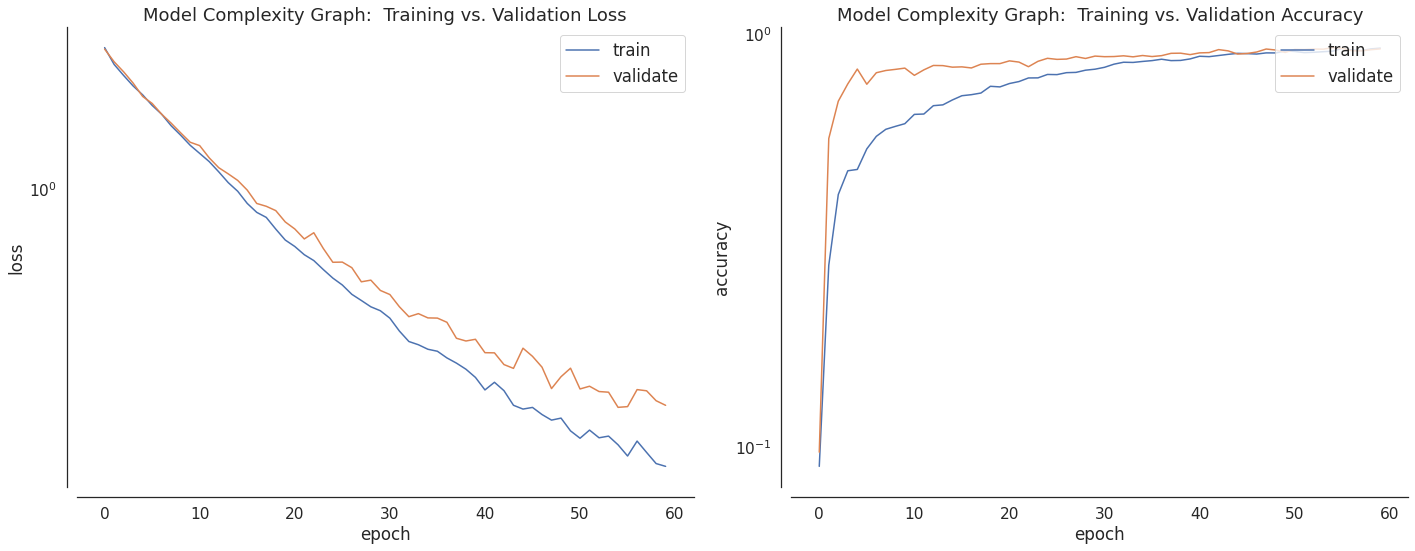

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

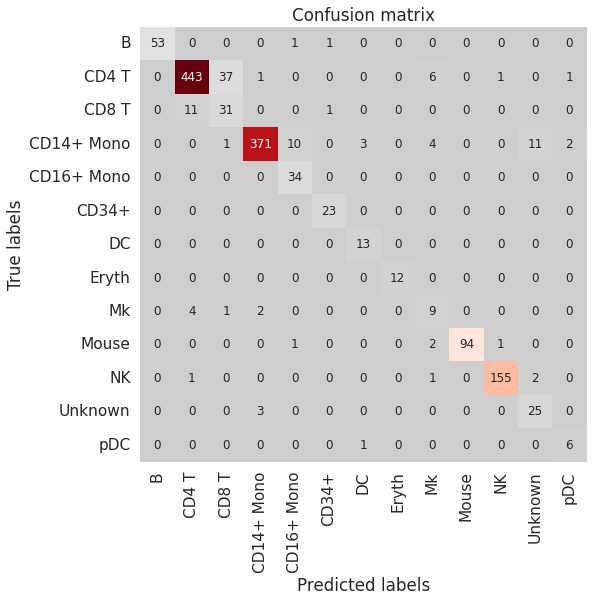

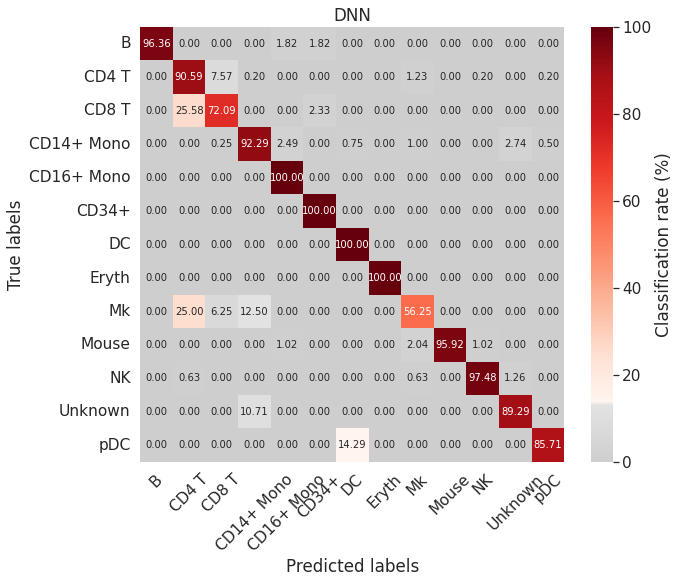

              precision    recall  f1-score   support

           B       1.00      0.96      0.98        55
       CD4 T       0.97      0.91      0.93       489
       CD8 T       0.44      0.72      0.55        43
  CD14+ Mono       0.98      0.92      0.95       402
  CD16+ Mono       0.74      1.00      0.85        34
       CD34+       0.92      1.00      0.96        23
          DC       0.76      1.00      0.87        13
       Eryth       1.00      1.00      1.00        12
          Mk       0.41      0.56      0.47        16
       Mouse       1.00      0.96      0.98        98
          NK       0.99      0.97      0.98       159
     Unknown       0.66      0.89      0.76        28
         pDC       0.67      0.86      0.75         7

    accuracy                           0.92      1379
   macro avg       0.81      0.90      0.85      1379
weighted avg       0.94      0.92      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2618 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


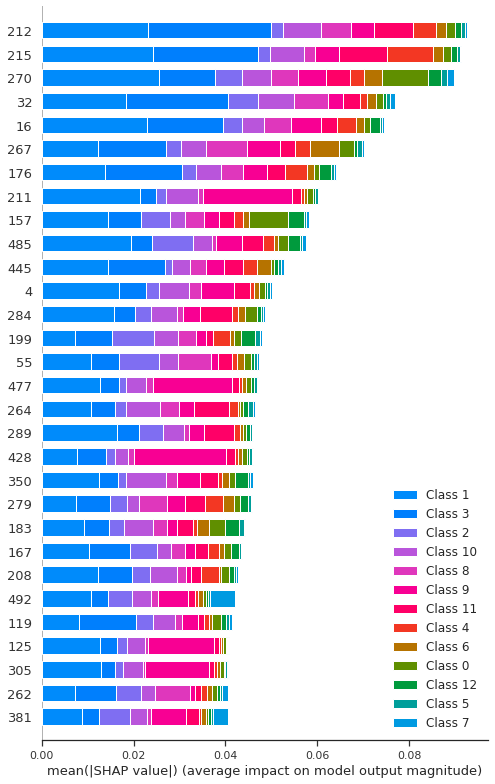

 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7771 - accuracy: 0.7336 - auc: 0.9772 - precision: 0.9598 - recall: 0.3074 - val_loss: 0.8503 - val_accuracy: 0.8390 - val_auc: 0.9901 - val_precision: 0.9635 - val_recall: 0.3640

Epoch 00019: val_loss improved from 0.89857 to 0.85034, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7258 - accuracy: 0.7466 - auc: 0.9794 - precision: 0.9536 - recall: 0.3431 - val_loss: 0.8002 - val_accuracy: 0.8644 - val_auc: 0.9914 - val_precision: 0.9613 - val_recall: 0.3967

Epoch 00020: val_loss improved from 0.85034 to 0.80018, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.7595 - auc: 0.9815 - precision: 0.9423 - recall: 0.3794 - val_loss: 0.7279 - val_accuracy: 0.8767 - val_auc: 0.9926 - val_precision: 0.9557 - val_recall: 0.4692

Epoch 00021: val_loss improved f

Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2879 - accuracy: 0.8839 - auc: 0.9954 - precision: 0.9366 - recall: 0.8036 - val_loss: 0.3923 - val_accuracy: 0.8970 - val_auc: 0.9947 - val_precision: 0.9206 - val_recall: 0.8571

Epoch 00043: val_loss did not improve from 0.34442
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2774 - accuracy: 0.8807 - auc: 0.9949 - precision: 0.9282 - recall: 0.8020 - val_loss: 0.3354 - val_accuracy: 0.9166 - val_auc: 0.9956 - val_precision: 0.9345 - val_recall: 0.8796

Epoch 00044: val_loss improved from 0.34442 to 0.33538, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2582 - accuracy: 0.8983 - auc: 0.9963 - precision: 0.9402 - recall: 0.8239 - val_loss: 0.3209 - val_accuracy: 0.9202 - val_auc: 0.9958 - val_precision: 0.9371 - val_recall: 0.8854

Epoch 00045: val_loss improved from 0.33538 to 0.32094, saving model to w


Epoch 00067: val_loss did not improve from 0.23747
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9333 - auc: 0.9980 - precision: 0.9549 - recall: 0.9068 - val_loss: 0.2427 - val_accuracy: 0.9289 - val_auc: 0.9948 - val_precision: 0.9376 - val_recall: 0.9152

Epoch 00068: val_loss did not improve from 0.23747
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.9362 - auc: 0.9983 - precision: 0.9545 - recall: 0.9095 - val_loss: 0.2607 - val_accuracy: 0.9217 - val_auc: 0.9948 - val_precision: 0.9304 - val_recall: 0.9108

Epoch 00069: val_loss did not improve from 0.23747
Epoch 70/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1404 - accuracy: 0.9356 - auc: 0.9984 - precision: 0.9544 - recall: 0.9100 - val_loss: 0.2405 - val_accuracy: 0.9275 - val_auc: 0.9949 - val_precision: 0.9372 - val_recall: 0.9195

Epoch 00070: val_loss did not improve from 0.23747
Epoch 00070: early stopp

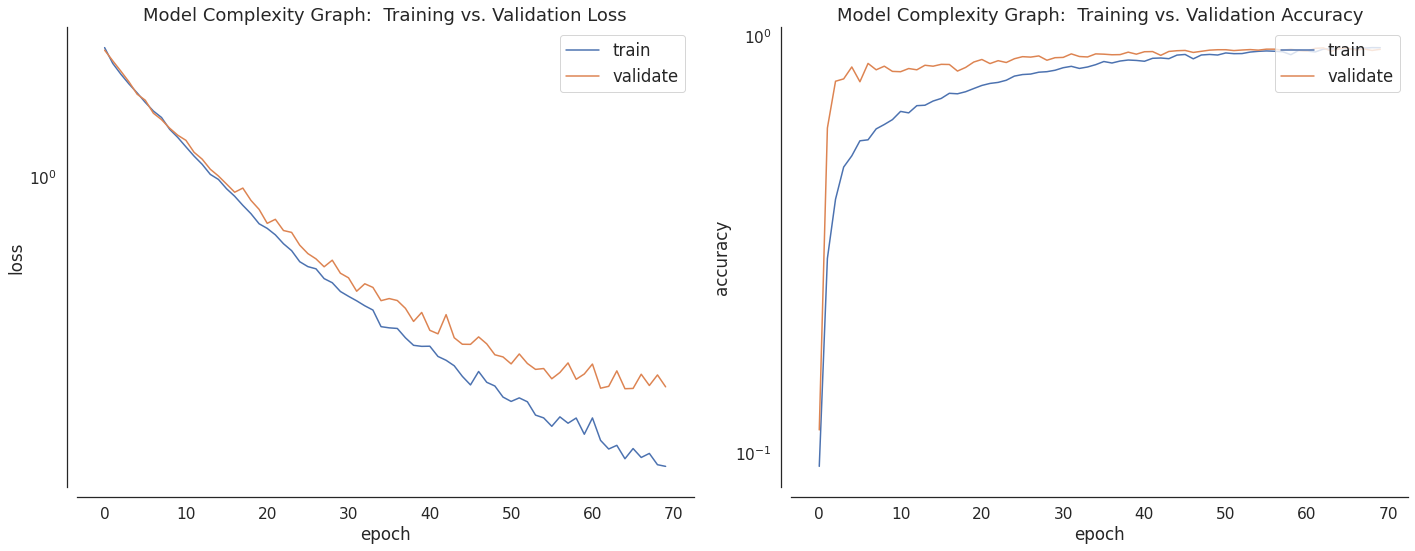

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

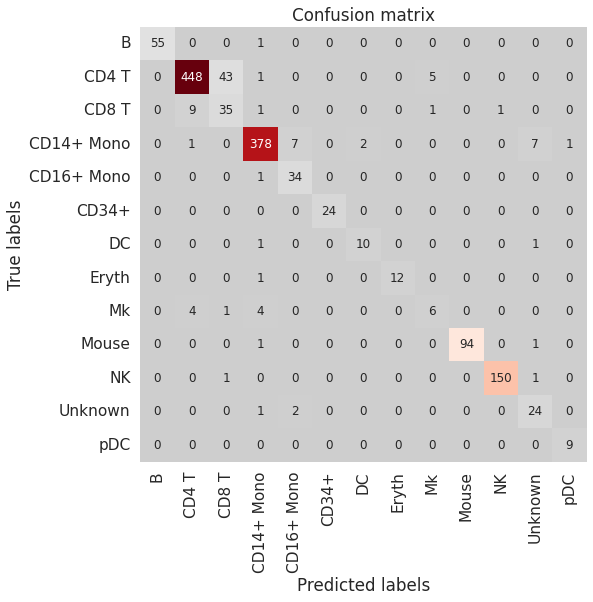

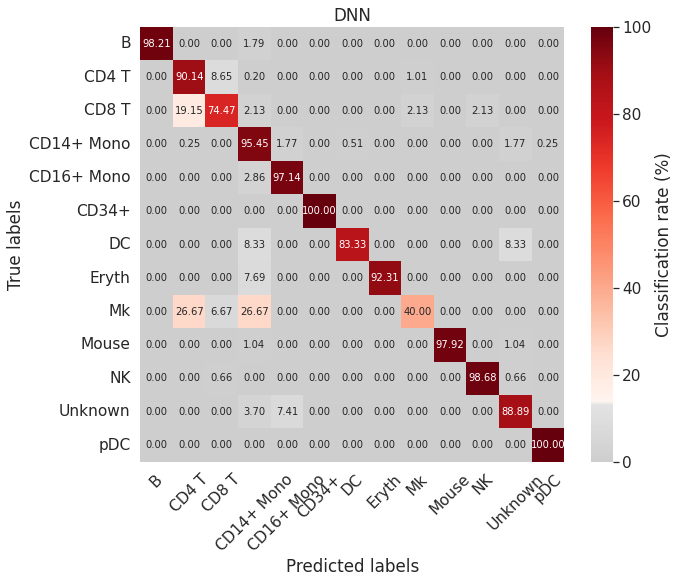

              precision    recall  f1-score   support

           B       1.00      0.98      0.99        56
       CD4 T       0.97      0.90      0.93       497
       CD8 T       0.44      0.74      0.55        47
  CD14+ Mono       0.97      0.95      0.96       396
  CD16+ Mono       0.79      0.97      0.87        35
       CD34+       1.00      1.00      1.00        24
          DC       0.83      0.83      0.83        12
       Eryth       1.00      0.92      0.96        13
          Mk       0.50      0.40      0.44        15
       Mouse       1.00      0.98      0.99        96
          NK       0.99      0.99      0.99       152
     Unknown       0.71      0.89      0.79        27
         pDC       0.90      1.00      0.95         9

    accuracy                           0.93      1379
   macro avg       0.85      0.89      0.87      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2375 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


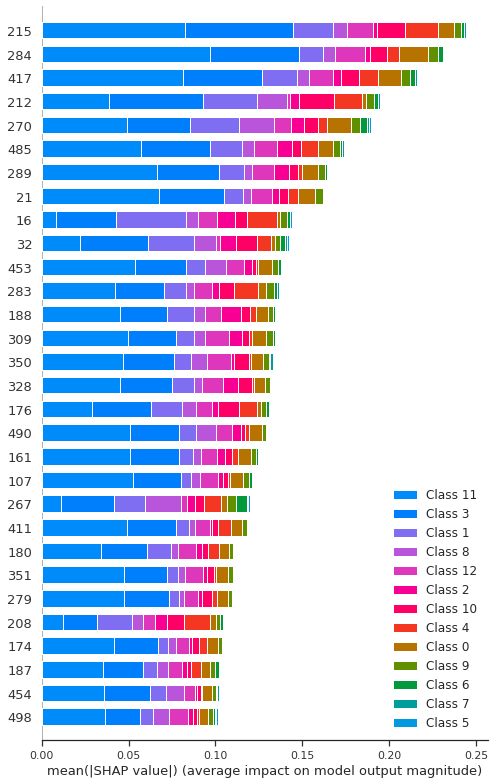

 * Initialising ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
activation_28 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)                64        
_________________________________________________________________
activation_29 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7760 - accuracy: 0.7488 - auc: 0.9799 - precision: 0.9527 - recall: 0.3105 - val_loss: 0.8638 - val_accuracy: 0.8216 - val_auc: 0.9892 - val_precision: 0.9795 - val_recall: 0.3466

Epoch 00019: val_loss improved from 0.86693 to 0.86380, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7328 - accuracy: 0.7515 - auc: 0.9802 - precision: 0.9553 - recall: 0.3410 - val_loss: 0.7916 - val_accuracy: 0.8455 - val_auc: 0.9915 - val_precision: 0.9703 - val_recall: 0.4025

Epoch 00020: val_loss improved from 0.86380 to 0.79157, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.7633 - auc: 0.9816 - precision: 0.9389 - recall: 0.3705 - val_loss: 0.7782 - val_accuracy: 0.8405 - val_auc: 0.9910 - val_precision: 0.9554 - val_recall: 0.4191

Epoch 00021: val_loss improved f

56/56 [==============================] - 0s 3ms/step - loss: 0.2988 - accuracy: 0.8843 - auc: 0.9952 - precision: 0.9376 - recall: 0.7987 - val_loss: 0.3379 - val_accuracy: 0.8985 - val_auc: 0.9963 - val_precision: 0.9311 - val_recall: 0.8724

Epoch 00042: val_loss improved from 0.37624 to 0.33791, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2764 - accuracy: 0.8867 - auc: 0.9958 - precision: 0.9460 - recall: 0.8072 - val_loss: 0.3258 - val_accuracy: 0.9065 - val_auc: 0.9966 - val_precision: 0.9286 - val_recall: 0.8774

Epoch 00043: val_loss improved from 0.33791 to 0.32582, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2637 - accuracy: 0.9004 - auc: 0.9962 - precision: 0.9439 - recall: 0.8237 - val_loss: 0.3013 - val_accuracy: 0.9144 - val_auc: 0.9970 - val_precision: 0.9326 - val_recall: 0.8927

Epoch 00044: val_loss improved f

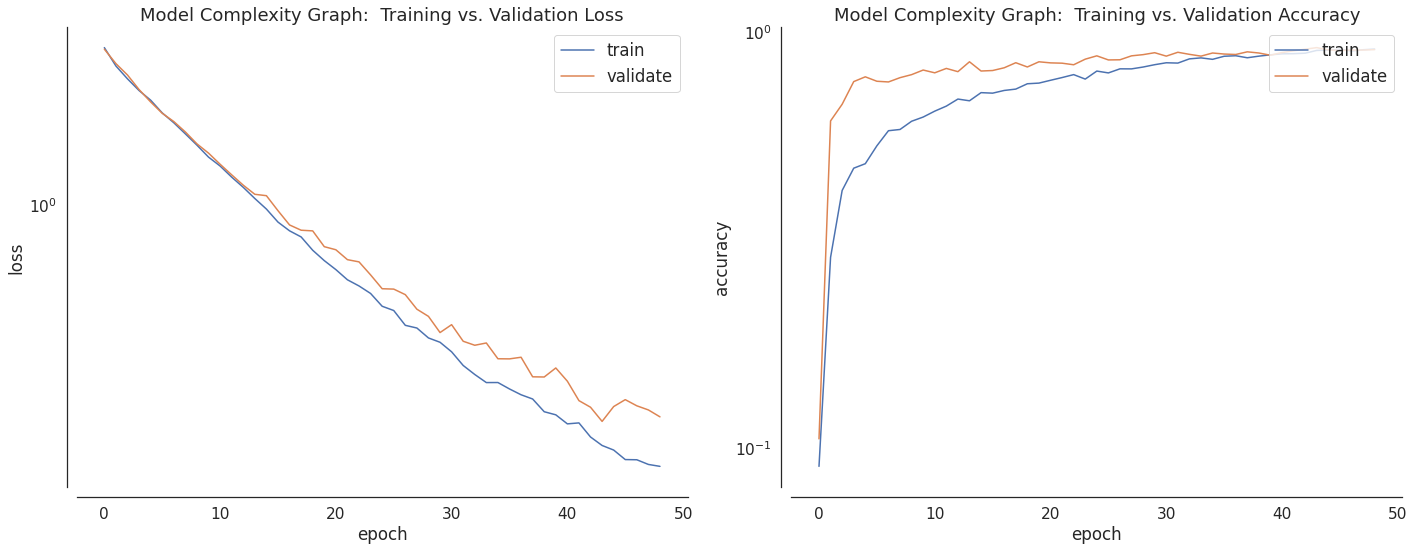

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

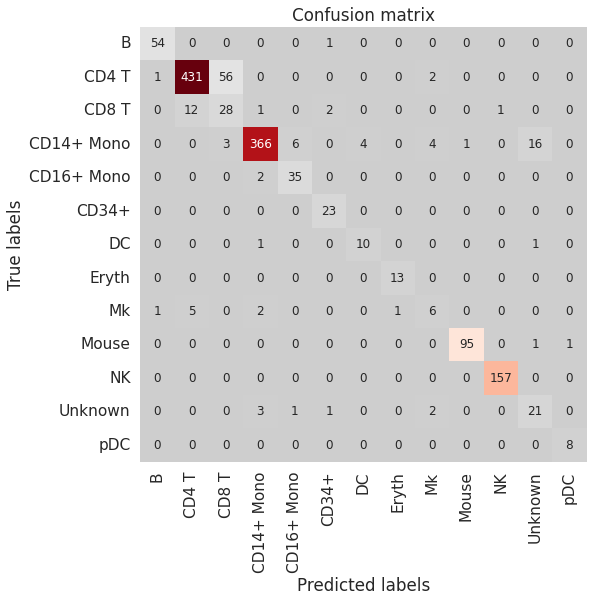

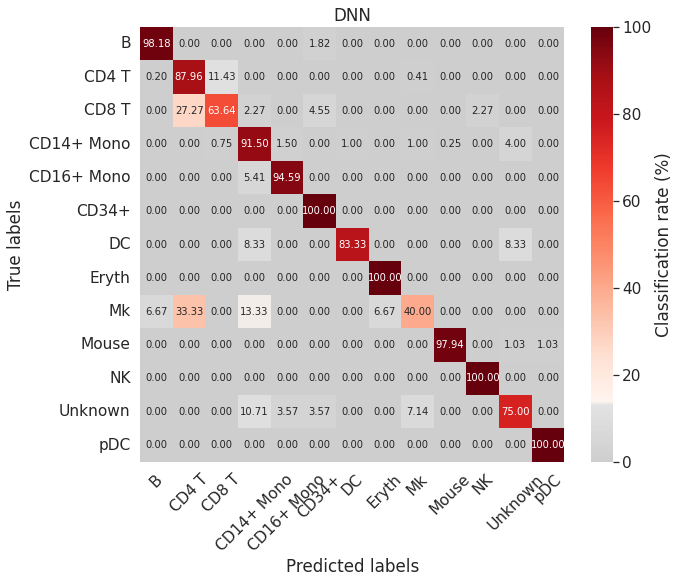

              precision    recall  f1-score   support

           B       0.96      0.98      0.97        55
       CD4 T       0.96      0.88      0.92       490
       CD8 T       0.32      0.64      0.43        44
  CD14+ Mono       0.98      0.92      0.94       400
  CD16+ Mono       0.83      0.95      0.89        37
       CD34+       0.85      1.00      0.92        23
          DC       0.71      0.83      0.77        12
       Eryth       0.93      1.00      0.96        13
          Mk       0.43      0.40      0.41        15
       Mouse       0.99      0.98      0.98        97
          NK       0.99      1.00      1.00       157
     Unknown       0.54      0.75      0.63        28
         pDC       0.89      1.00      0.94         8

    accuracy                           0.90      1379
   macro avg       0.80      0.87      0.83      1379
weighted avg       0.93      0.90      0.91      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.3013 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


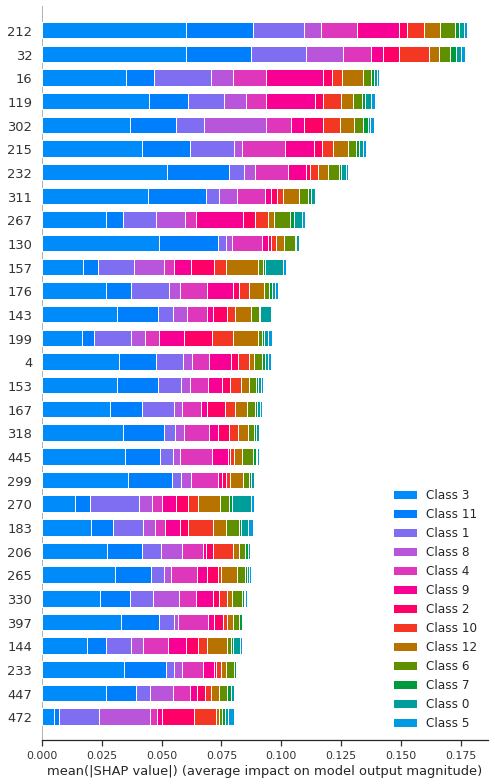

 * Initialising ...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_32 (Batc (None, 32)                128       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
activation_33 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7788 - accuracy: 0.7497 - auc: 0.9797 - precision: 0.9595 - recall: 0.3137 - val_loss: 0.8432 - val_accuracy: 0.8673 - val_auc: 0.9912 - val_precision: 0.9784 - val_recall: 0.3619

Epoch 00019: val_loss did not improve from 0.83873
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7471 - accuracy: 0.7566 - auc: 0.9800 - precision: 0.9601 - recall: 0.3448 - val_loss: 0.7913 - val_accuracy: 0.8731 - val_auc: 0.9919 - val_precision: 0.9700 - val_recall: 0.3981

Epoch 00020: val_loss improved from 0.83873 to 0.79132, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.7452 - auc: 0.9799 - precision: 0.9331 - recall: 0.3620 - val_loss: 0.7720 - val_accuracy: 0.8586 - val_auc: 0.9909 - val_precision: 0.9455 - val_recall: 0.4278

Epoch 00021: val_loss improved from 0.79132 to 0.77201, saving model to weights/best_m

56/56 [==============================] - 0s 3ms/step - loss: 0.2832 - accuracy: 0.8897 - auc: 0.9952 - precision: 0.9389 - recall: 0.8081 - val_loss: 0.3001 - val_accuracy: 0.9260 - val_auc: 0.9968 - val_precision: 0.9436 - val_recall: 0.8970

Epoch 00043: val_loss improved from 0.31207 to 0.30006, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2664 - accuracy: 0.8886 - auc: 0.9956 - precision: 0.9357 - recall: 0.8157 - val_loss: 0.3028 - val_accuracy: 0.9239 - val_auc: 0.9964 - val_precision: 0.9398 - val_recall: 0.8941

Epoch 00044: val_loss did not improve from 0.30006
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2594 - accuracy: 0.8921 - auc: 0.9953 - precision: 0.9364 - recall: 0.8118 - val_loss: 0.2748 - val_accuracy: 0.9282 - val_auc: 0.9968 - val_precision: 0.9463 - val_recall: 0.9065

Epoch 00045: val_loss improved from 0.30006 to 0.27477, saving model to weights/best_m

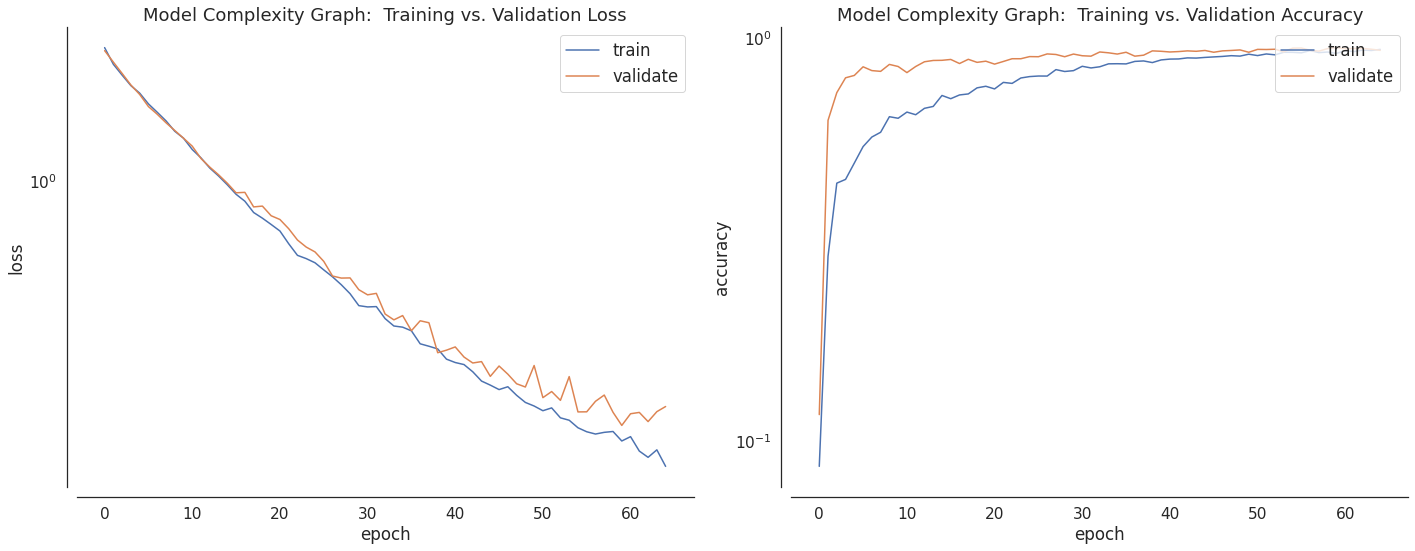

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

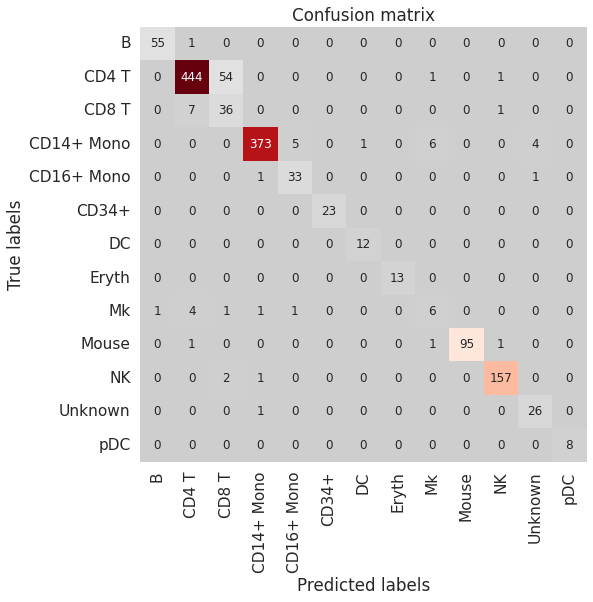

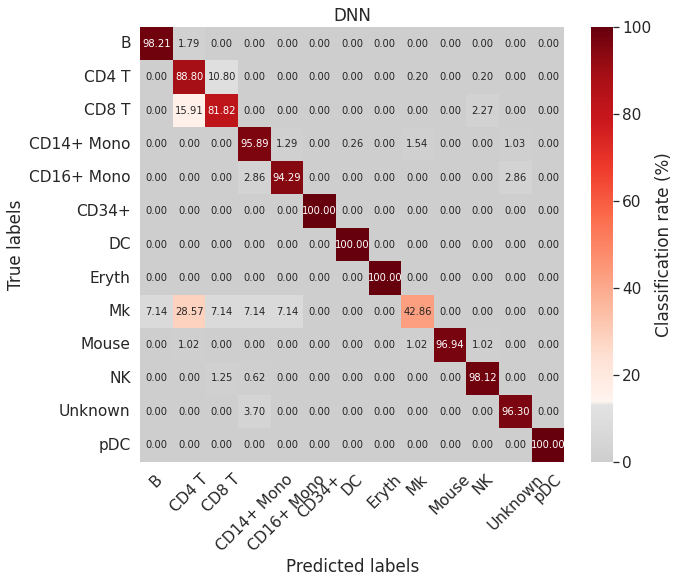

              precision    recall  f1-score   support

           B       0.98      0.98      0.98        56
       CD4 T       0.97      0.89      0.93       500
       CD8 T       0.39      0.82      0.53        44
  CD14+ Mono       0.99      0.96      0.97       389
  CD16+ Mono       0.85      0.94      0.89        35
       CD34+       1.00      1.00      1.00        23
          DC       0.92      1.00      0.96        12
       Eryth       1.00      1.00      1.00        13
          Mk       0.43      0.43      0.43        14
       Mouse       1.00      0.97      0.98        98
          NK       0.98      0.98      0.98       160
     Unknown       0.84      0.96      0.90        27
         pDC       1.00      1.00      1.00         8

    accuracy                           0.93      1379
   macro avg       0.87      0.92      0.89      1379
weighted avg       0.95      0.93      0.94      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.1989 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


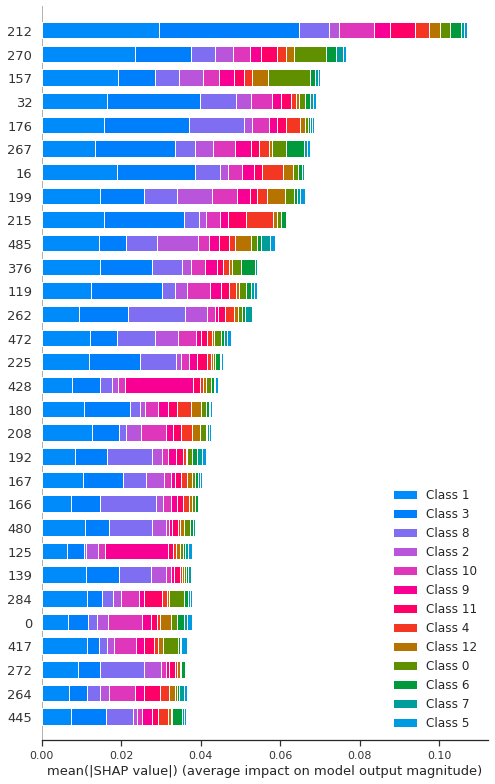

 * Initialising ...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
activation_36 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16)                64        
_________________________________________________________________
activation_37 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7821 - accuracy: 0.7486 - auc: 0.9797 - precision: 0.9546 - recall: 0.3054 - val_loss: 0.8969 - val_accuracy: 0.8115 - val_auc: 0.9877 - val_precision: 0.9538 - val_recall: 0.3147

Epoch 00019: val_loss did not improve from 0.87435
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7329 - accuracy: 0.7399 - auc: 0.9797 - precision: 0.9436 - recall: 0.3308 - val_loss: 0.8170 - val_accuracy: 0.8455 - val_auc: 0.9909 - val_precision: 0.9606 - val_recall: 0.3713

Epoch 00020: val_loss improved from 0.87435 to 0.81699, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.7615 - auc: 0.9816 - precision: 0.9466 - recall: 0.3727 - val_loss: 0.7457 - val_accuracy: 0.8731 - val_auc: 0.9926 - val_precision: 0.9571 - val_recall: 0.4525

Epoch 00021: val_loss improved from 0.81699 to 0.74572, saving model to weights/best_m


Epoch 00042: val_loss improved from 0.37704 to 0.34972, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2824 - accuracy: 0.8790 - auc: 0.9947 - precision: 0.9292 - recall: 0.8001 - val_loss: 0.3501 - val_accuracy: 0.9079 - val_auc: 0.9965 - val_precision: 0.9333 - val_recall: 0.8629

Epoch 00043: val_loss did not improve from 0.34972
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2801 - accuracy: 0.8865 - auc: 0.9951 - precision: 0.9339 - recall: 0.8074 - val_loss: 0.3295 - val_accuracy: 0.9166 - val_auc: 0.9967 - val_precision: 0.9370 - val_recall: 0.8731

Epoch 00044: val_loss improved from 0.34972 to 0.32954, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2751 - accuracy: 0.8910 - auc: 0.9958 - precision: 0.9302 - recall: 0.8143 - val_loss: 0.3155 - val_accuracy: 0.9152 - val_auc: 0.9970 - val_precisi

56/56 [==============================] - 0s 3ms/step - loss: 0.1599 - accuracy: 0.9273 - auc: 0.9980 - precision: 0.9507 - recall: 0.8961 - val_loss: 0.2414 - val_accuracy: 0.9210 - val_auc: 0.9967 - val_precision: 0.9363 - val_recall: 0.9065

Epoch 00067: val_loss did not improve from 0.22628
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1599 - accuracy: 0.9269 - auc: 0.9979 - precision: 0.9529 - recall: 0.8948 - val_loss: 0.2382 - val_accuracy: 0.9224 - val_auc: 0.9968 - val_precision: 0.9340 - val_recall: 0.9137

Epoch 00068: val_loss did not improve from 0.22628
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1521 - accuracy: 0.9311 - auc: 0.9980 - precision: 0.9510 - recall: 0.9046 - val_loss: 0.2205 - val_accuracy: 0.9282 - val_auc: 0.9971 - val_precision: 0.9384 - val_recall: 0.9173

Epoch 00069: val_loss improved from 0.22628 to 0.22045, saving model to weights/best_model_annotation.h5
Epoch 70/100
56/56 [===============

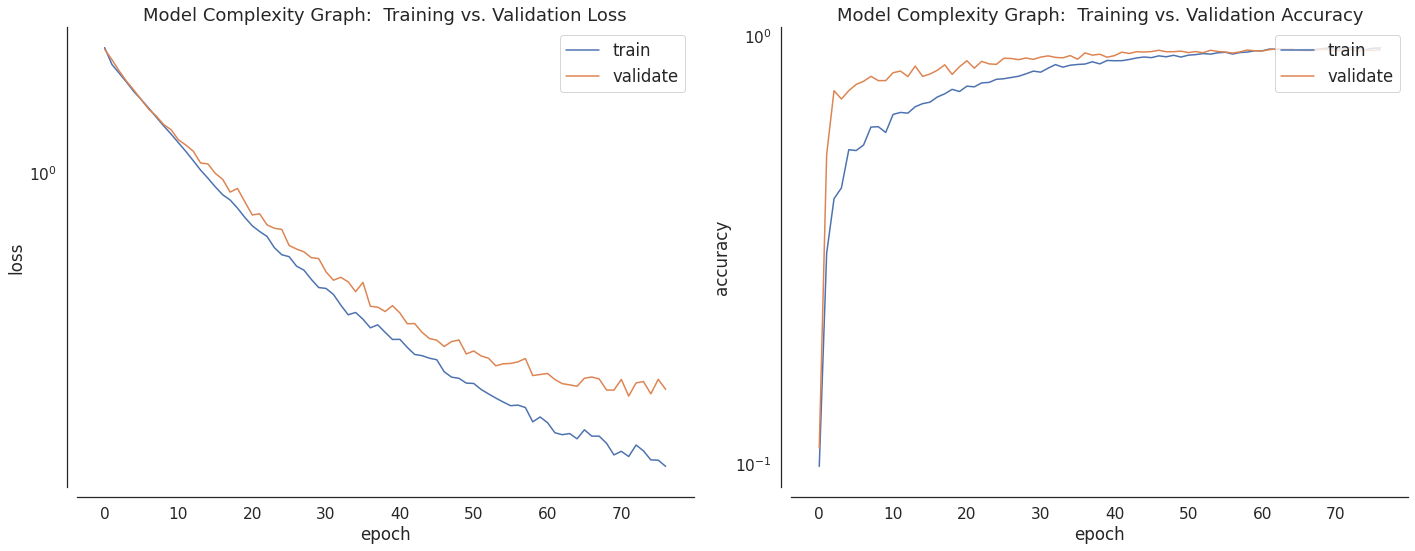

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

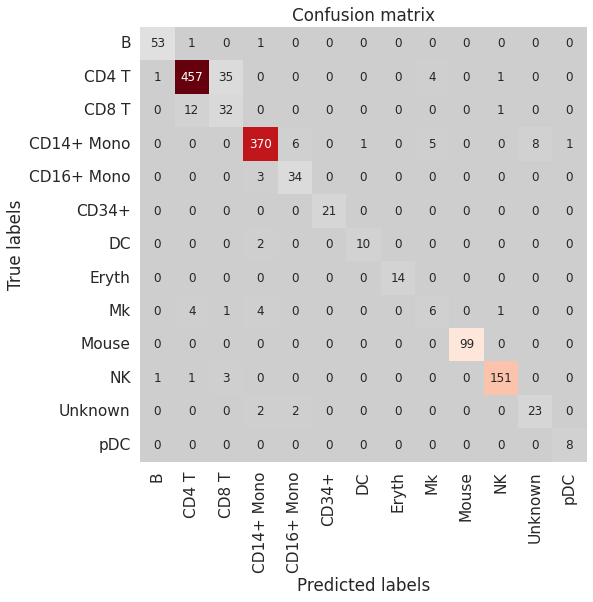

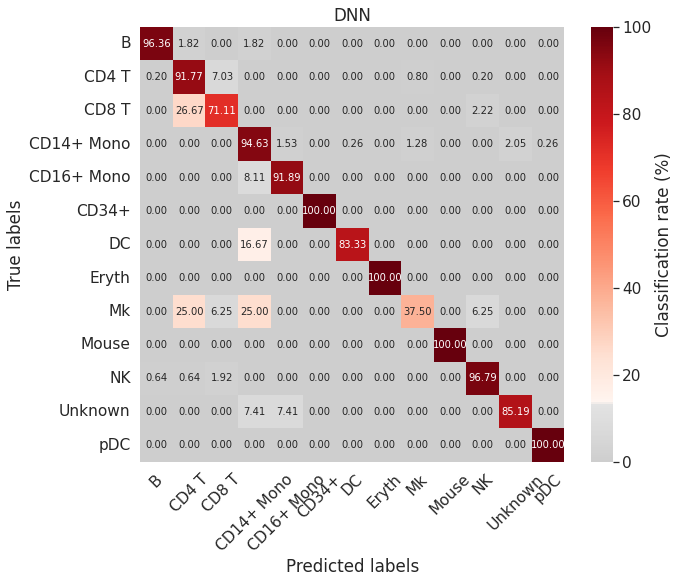

              precision    recall  f1-score   support

           B       0.96      0.96      0.96        55
       CD4 T       0.96      0.92      0.94       498
       CD8 T       0.45      0.71      0.55        45
  CD14+ Mono       0.97      0.95      0.96       391
  CD16+ Mono       0.81      0.92      0.86        37
       CD34+       1.00      1.00      1.00        21
          DC       0.91      0.83      0.87        12
       Eryth       1.00      1.00      1.00        14
          Mk       0.40      0.38      0.39        16
       Mouse       1.00      1.00      1.00        99
          NK       0.98      0.97      0.97       156
     Unknown       0.74      0.85      0.79        27
         pDC       0.89      1.00      0.94         8

    accuracy                           0.93      1379
   macro avg       0.85      0.88      0.86      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2114 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


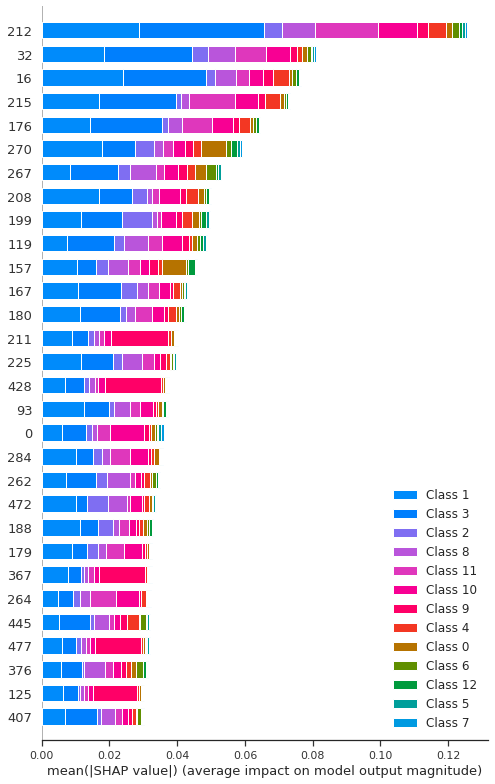

 * Initialising ...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_40 (Batc (None, 32)                128       
_________________________________________________________________
activation_40 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_41 (Batc (None, 16)                64        
_________________________________________________________________
activation_41 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7673 - accuracy: 0.7461 - auc: 0.9784 - precision: 0.9529 - recall: 0.3119 - val_loss: 0.8915 - val_accuracy: 0.8463 - val_auc: 0.9891 - val_precision: 0.9580 - val_recall: 0.3140

Epoch 00019: val_loss improved from 0.90633 to 0.89147, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7473 - accuracy: 0.7488 - auc: 0.9795 - precision: 0.9436 - recall: 0.3397 - val_loss: 0.8100 - val_accuracy: 0.8615 - val_auc: 0.9909 - val_precision: 0.9561 - val_recall: 0.3793

Epoch 00020: val_loss improved from 0.89147 to 0.81005, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.7708 - auc: 0.9826 - precision: 0.9437 - recall: 0.3801 - val_loss: 0.7613 - val_accuracy: 0.8745 - val_auc: 0.9918 - val_precision: 0.9577 - val_recall: 0.4438

Epoch 00021: val_loss improved f


Epoch 00042: val_loss improved from 0.37016 to 0.34035, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2810 - accuracy: 0.8905 - auc: 0.9953 - precision: 0.9402 - recall: 0.8074 - val_loss: 0.3384 - val_accuracy: 0.9195 - val_auc: 0.9959 - val_precision: 0.9379 - val_recall: 0.8876

Epoch 00043: val_loss improved from 0.34035 to 0.33837, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2702 - accuracy: 0.9003 - auc: 0.9960 - precision: 0.9431 - recall: 0.8230 - val_loss: 0.3392 - val_accuracy: 0.9144 - val_auc: 0.9958 - val_precision: 0.9321 - val_recall: 0.8861

Epoch 00044: val_loss did not improve from 0.33837
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2604 - accuracy: 0.8972 - auc: 0.9959 - precision: 0.9383 - recall: 0.8277 - val_loss: 0.3211 - val_accuracy: 0.9152 - val_auc: 0.9958 - val_precisi

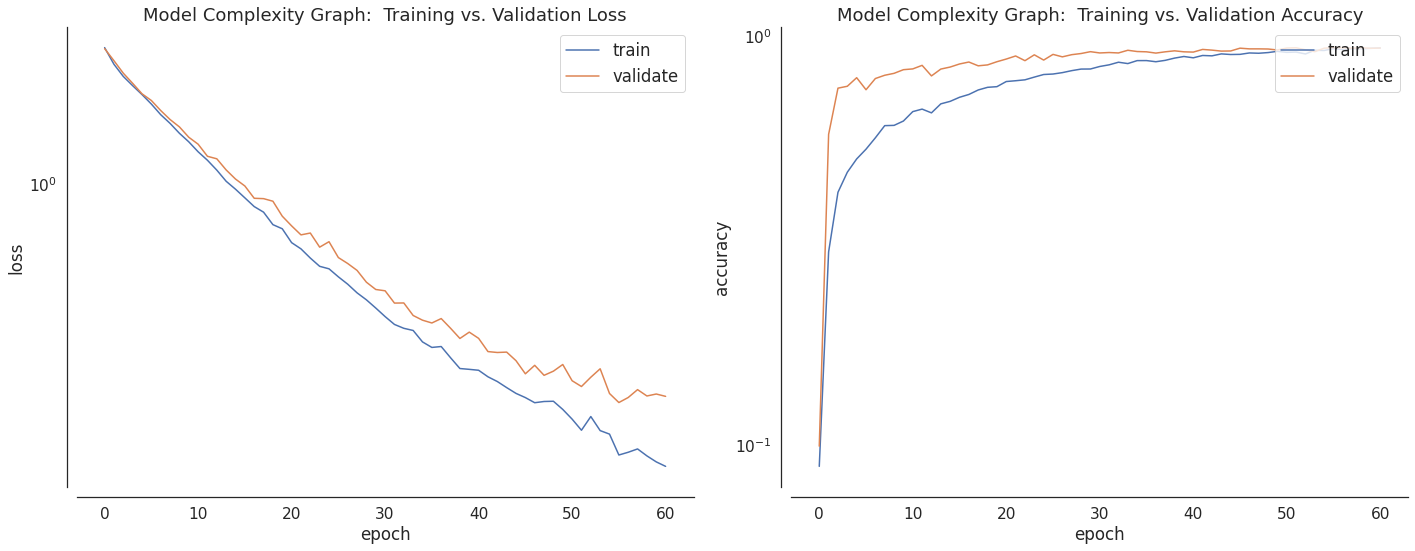

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

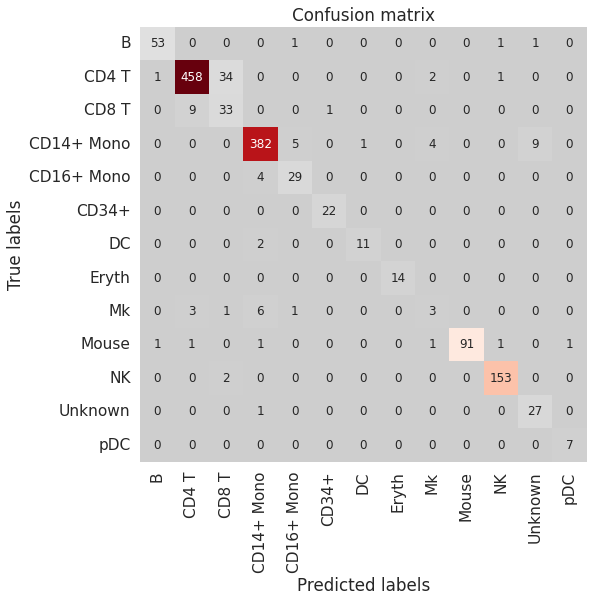

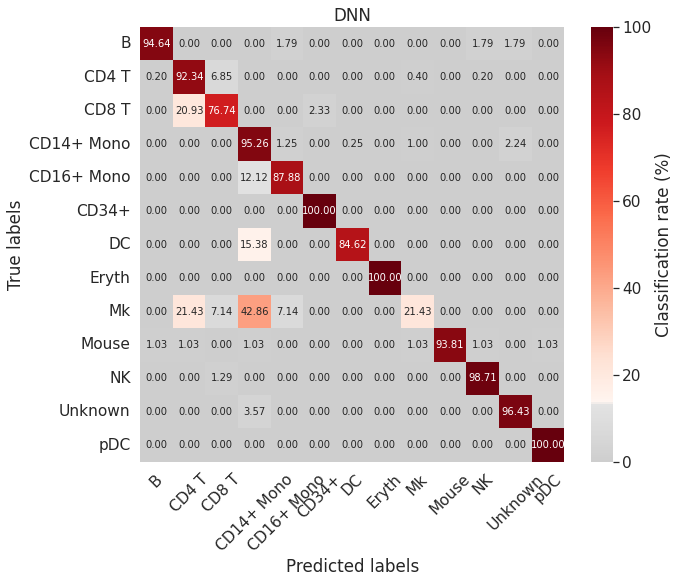

              precision    recall  f1-score   support

           B       0.96      0.95      0.95        56
       CD4 T       0.97      0.92      0.95       496
       CD8 T       0.47      0.77      0.58        43
  CD14+ Mono       0.96      0.95      0.96       401
  CD16+ Mono       0.81      0.88      0.84        33
       CD34+       0.96      1.00      0.98        22
          DC       0.92      0.85      0.88        13
       Eryth       1.00      1.00      1.00        14
          Mk       0.30      0.21      0.25        14
       Mouse       1.00      0.94      0.97        97
          NK       0.98      0.99      0.98       155
     Unknown       0.73      0.96      0.83        28
         pDC       0.88      1.00      0.93         7

    accuracy                           0.93      1379
   macro avg       0.84      0.88      0.85      1379
weighted avg       0.94      0.93      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2456 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


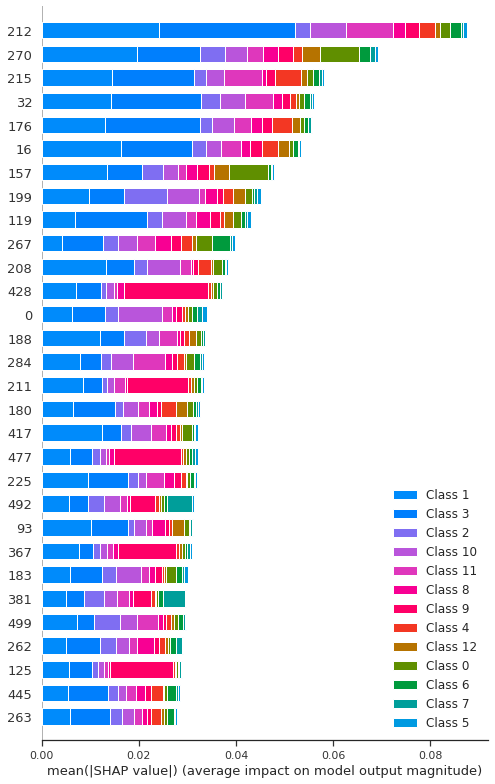

 * Initialising ...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32)                128       
_________________________________________________________________
activation_44 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_45 (Batc (None, 16)                64        
_________________________________________________________________
activation_45 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7885 - accuracy: 0.7495 - auc: 0.9786 - precision: 0.9538 - recall: 0.2996 - val_loss: 0.8570 - val_accuracy: 0.8658 - val_auc: 0.9906 - val_precision: 0.9706 - val_recall: 0.3358

Epoch 00019: val_loss improved from 0.87698 to 0.85700, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7618 - accuracy: 0.7615 - auc: 0.9803 - precision: 0.9495 - recall: 0.3377 - val_loss: 0.7937 - val_accuracy: 0.8702 - val_auc: 0.9917 - val_precision: 0.9758 - val_recall: 0.4090

Epoch 00020: val_loss improved from 0.85700 to 0.79366, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.7599 - auc: 0.9810 - precision: 0.9451 - recall: 0.3653 - val_loss: 0.7694 - val_accuracy: 0.8731 - val_auc: 0.9918 - val_precision: 0.9678 - val_recall: 0.4358

Epoch 00021: val_loss improved f

56/56 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.8921 - auc: 0.9952 - precision: 0.9381 - recall: 0.8025 - val_loss: 0.3600 - val_accuracy: 0.9007 - val_auc: 0.9956 - val_precision: 0.9321 - val_recall: 0.8666

Epoch 00042: val_loss improved from 0.36370 to 0.36003, saving model to weights/best_model_annotation.h5
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2930 - accuracy: 0.8917 - auc: 0.9957 - precision: 0.9423 - recall: 0.8112 - val_loss: 0.3563 - val_accuracy: 0.9072 - val_auc: 0.9956 - val_precision: 0.9323 - val_recall: 0.8687

Epoch 00043: val_loss improved from 0.36003 to 0.35633, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2742 - accuracy: 0.8966 - auc: 0.9959 - precision: 0.9409 - recall: 0.8177 - val_loss: 0.3588 - val_accuracy: 0.8985 - val_auc: 0.9954 - val_precision: 0.9244 - val_recall: 0.8687

Epoch 00044: val_loss did not im

56/56 [==============================] - 0s 3ms/step - loss: 0.1542 - accuracy: 0.9329 - auc: 0.9980 - precision: 0.9563 - recall: 0.9012 - val_loss: 0.2628 - val_accuracy: 0.9217 - val_auc: 0.9958 - val_precision: 0.9342 - val_recall: 0.9057

Epoch 00066: val_loss did not improve from 0.25427
Epoch 67/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1572 - accuracy: 0.9334 - auc: 0.9981 - precision: 0.9561 - recall: 0.9039 - val_loss: 0.2585 - val_accuracy: 0.9231 - val_auc: 0.9956 - val_precision: 0.9372 - val_recall: 0.9094

Epoch 00067: val_loss did not improve from 0.25427
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1489 - accuracy: 0.9318 - auc: 0.9979 - precision: 0.9527 - recall: 0.9024 - val_loss: 0.2540 - val_accuracy: 0.9268 - val_auc: 0.9953 - val_precision: 0.9368 - val_recall: 0.9144

Epoch 00068: val_loss improved from 0.25427 to 0.25397, saving model to weights/best_model_annotation.h5
Epoch 69/100
56/56 [===============

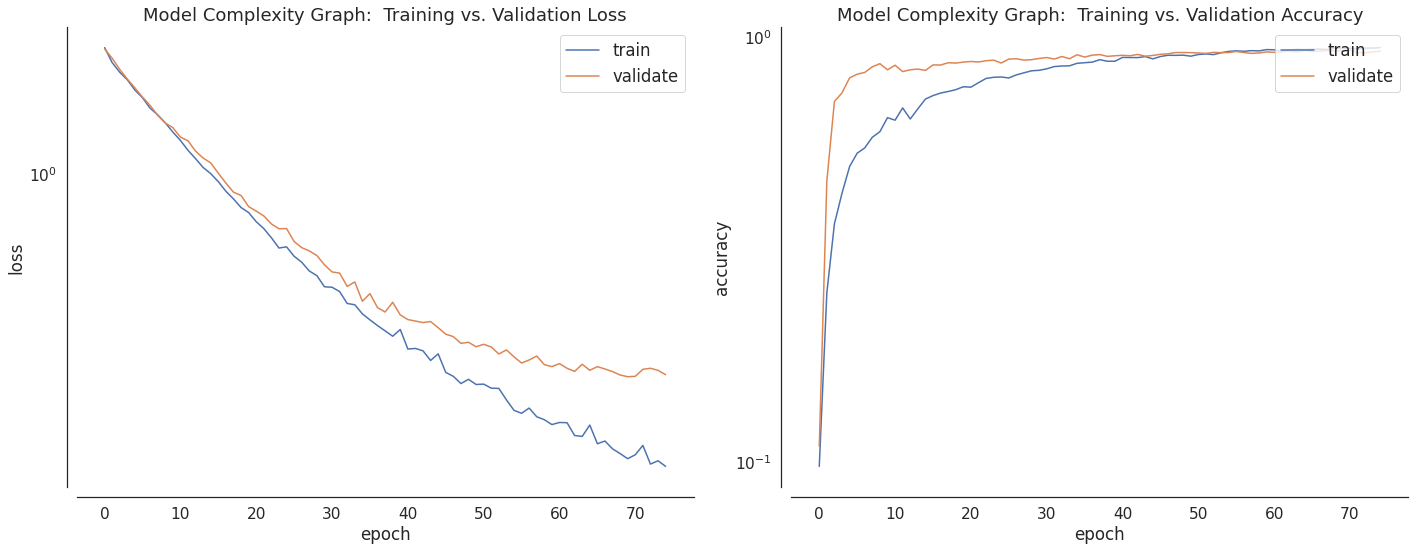

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

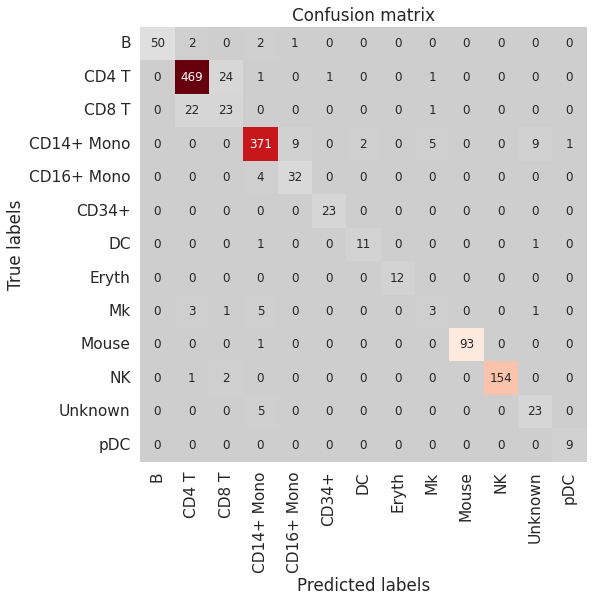

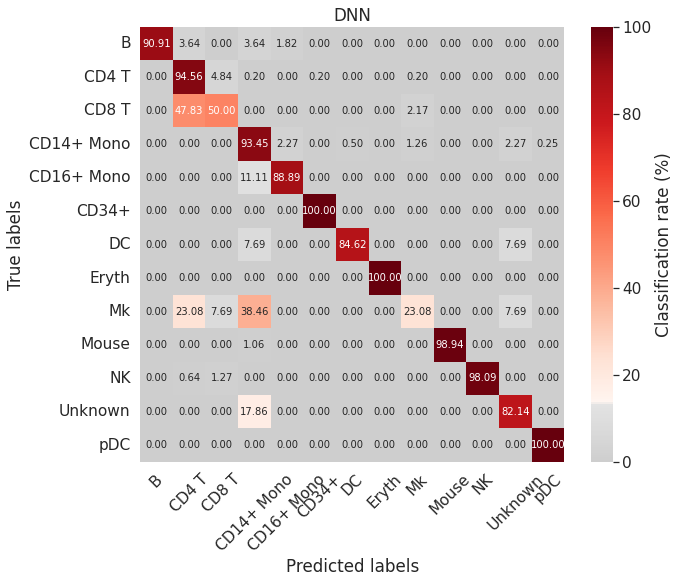

              precision    recall  f1-score   support

           B       1.00      0.91      0.95        55
       CD4 T       0.94      0.95      0.94       496
       CD8 T       0.46      0.50      0.48        46
  CD14+ Mono       0.95      0.93      0.94       397
  CD16+ Mono       0.76      0.89      0.82        36
       CD34+       0.96      1.00      0.98        23
          DC       0.85      0.85      0.85        13
       Eryth       1.00      1.00      1.00        12
          Mk       0.30      0.23      0.26        13
       Mouse       1.00      0.99      0.99        94
          NK       1.00      0.98      0.99       157
     Unknown       0.68      0.82      0.74        28
         pDC       0.90      1.00      0.95         9

    accuracy                           0.92      1379
   macro avg       0.83      0.85      0.84      1379
weighted avg       0.93      0.92      0.92      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2451 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


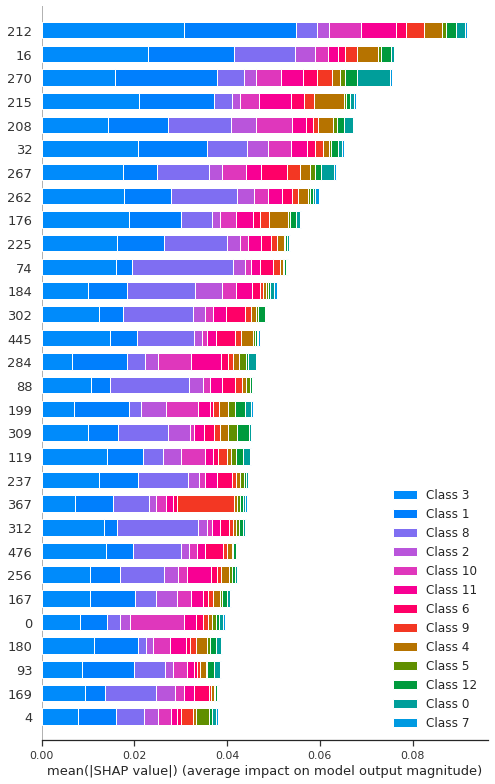

 * Initialising ...
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
activation_48 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_49 (Batc (None, 16)                64        
_________________________________________________________________
activation_49 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7581 - accuracy: 0.7514 - auc: 0.9801 - precision: 0.9455 - recall: 0.3148 - val_loss: 0.8278 - val_accuracy: 0.8550 - val_auc: 0.9907 - val_precision: 0.9684 - val_recall: 0.3553

Epoch 00019: val_loss improved from 0.87804 to 0.82781, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.7447 - auc: 0.9797 - precision: 0.9314 - recall: 0.3424 - val_loss: 0.7970 - val_accuracy: 0.8571 - val_auc: 0.9907 - val_precision: 0.9569 - val_recall: 0.4025

Epoch 00020: val_loss improved from 0.82781 to 0.79697, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.7428 - auc: 0.9807 - precision: 0.9317 - recall: 0.3810 - val_loss: 0.7627 - val_accuracy: 0.8535 - val_auc: 0.9912 - val_precision: 0.9560 - val_recall: 0.4416

Epoch 00021: val_loss improved f

56/56 [==============================] - 0s 3ms/step - loss: 0.2893 - accuracy: 0.8841 - auc: 0.9953 - precision: 0.9315 - recall: 0.7965 - val_loss: 0.3598 - val_accuracy: 0.9101 - val_auc: 0.9947 - val_precision: 0.9300 - val_recall: 0.8767

Epoch 00042: val_loss did not improve from 0.34467
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2869 - accuracy: 0.8827 - auc: 0.9948 - precision: 0.9319 - recall: 0.8012 - val_loss: 0.3402 - val_accuracy: 0.9159 - val_auc: 0.9954 - val_precision: 0.9332 - val_recall: 0.8920

Epoch 00043: val_loss improved from 0.34467 to 0.34020, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2841 - accuracy: 0.8914 - auc: 0.9954 - precision: 0.9371 - recall: 0.8130 - val_loss: 0.3286 - val_accuracy: 0.9181 - val_auc: 0.9951 - val_precision: 0.9311 - val_recall: 0.8920

Epoch 00044: val_loss improved from 0.34020 to 0.32858, saving model to weights/best_m

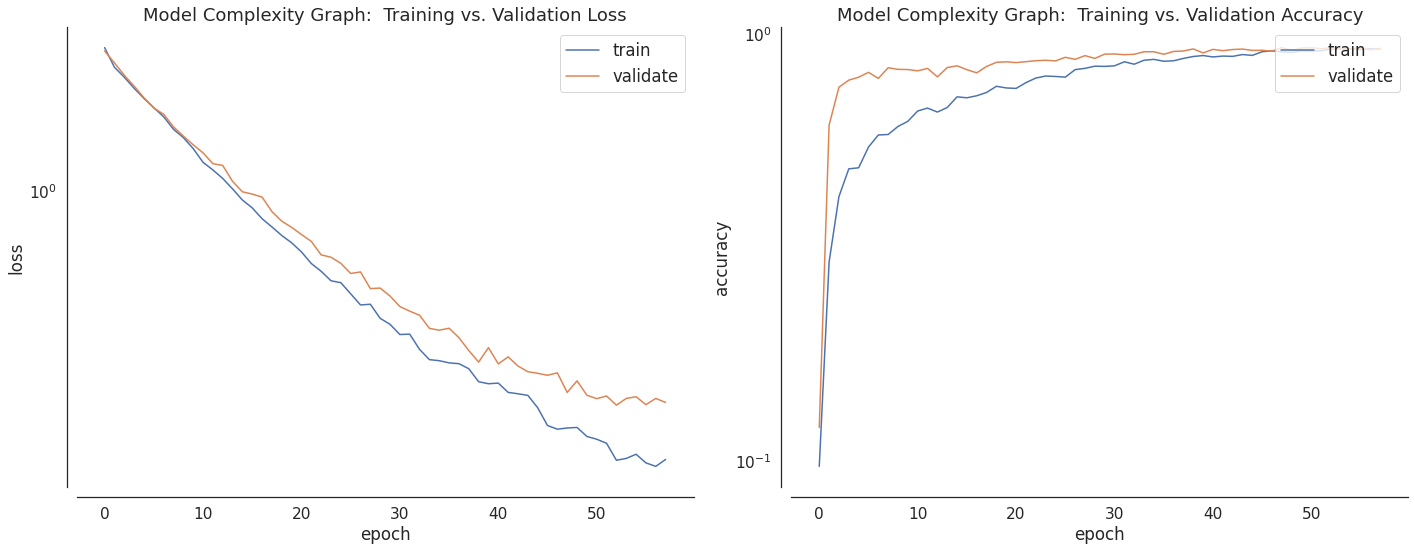

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

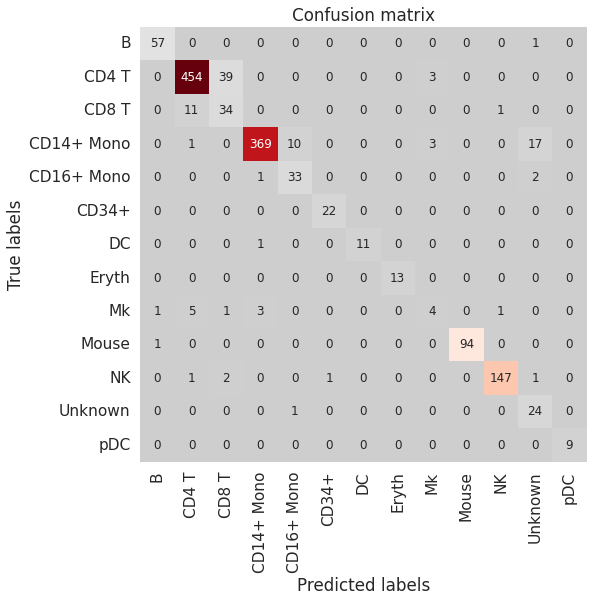

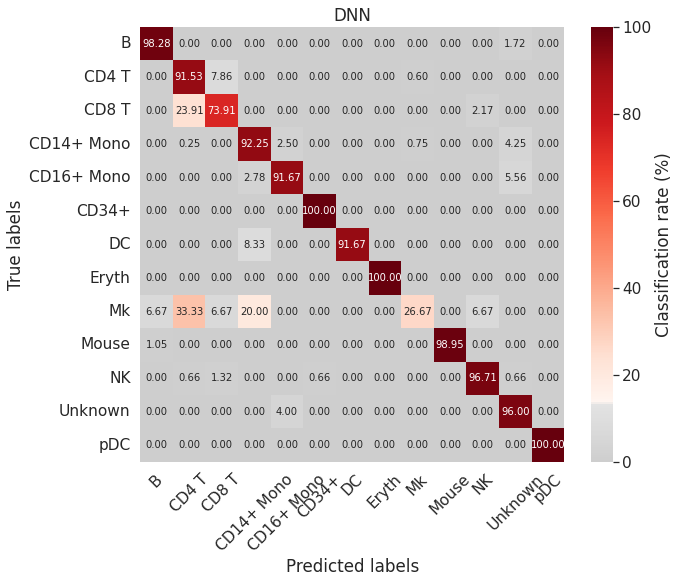

              precision    recall  f1-score   support

           B       0.97      0.98      0.97        58
       CD4 T       0.96      0.92      0.94       496
       CD8 T       0.45      0.74      0.56        46
  CD14+ Mono       0.99      0.92      0.95       400
  CD16+ Mono       0.75      0.92      0.83        36
       CD34+       0.96      1.00      0.98        22
          DC       1.00      0.92      0.96        12
       Eryth       1.00      1.00      1.00        13
          Mk       0.40      0.27      0.32        15
       Mouse       1.00      0.99      0.99        95
          NK       0.99      0.97      0.98       152
     Unknown       0.53      0.96      0.69        25
         pDC       1.00      1.00      1.00         9

    accuracy                           0.92      1379
   macro avg       0.85      0.89      0.86      1379
weighted avg       0.94      0.92      0.93      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


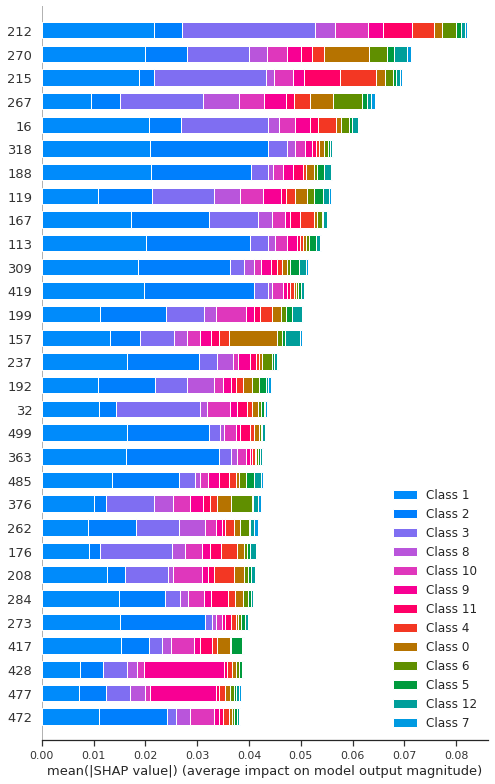

 * Initialising ...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_52 (Batc (None, 32)                128       
_________________________________________________________________
activation_52 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_53 (Batc (None, 16)                64        
_________________________________________________________________
activation_53 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7840 - accuracy: 0.7472 - auc: 0.9791 - precision: 0.9490 - recall: 0.2967 - val_loss: 0.8366 - val_accuracy: 0.8463 - val_auc: 0.9905 - val_precision: 0.9575 - val_recall: 0.3597

Epoch 00019: val_loss improved from 0.89818 to 0.83656, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7316 - accuracy: 0.7441 - auc: 0.9797 - precision: 0.9494 - recall: 0.3366 - val_loss: 0.8162 - val_accuracy: 0.8441 - val_auc: 0.9903 - val_precision: 0.9410 - val_recall: 0.3698

Epoch 00020: val_loss improved from 0.83656 to 0.81622, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.7612 - auc: 0.9810 - precision: 0.9392 - recall: 0.3616 - val_loss: 0.7754 - val_accuracy: 0.8477 - val_auc: 0.9909 - val_precision: 0.9369 - val_recall: 0.4090

Epoch 00021: val_loss improved f

Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2852 - accuracy: 0.8867 - auc: 0.9953 - precision: 0.9391 - recall: 0.8079 - val_loss: 0.3328 - val_accuracy: 0.9173 - val_auc: 0.9963 - val_precision: 0.9380 - val_recall: 0.8891

Epoch 00043: val_loss improved from 0.36913 to 0.33277, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2599 - accuracy: 0.8963 - auc: 0.9963 - precision: 0.9412 - recall: 0.8252 - val_loss: 0.3365 - val_accuracy: 0.9123 - val_auc: 0.9960 - val_precision: 0.9290 - val_recall: 0.8825

Epoch 00044: val_loss did not improve from 0.33277
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2603 - accuracy: 0.8928 - auc: 0.9958 - precision: 0.9367 - recall: 0.8237 - val_loss: 0.3386 - val_accuracy: 0.9086 - val_auc: 0.9958 - val_precision: 0.9254 - val_recall: 0.8818

Epoch 00045: val_loss did not improve from 0.33277
Epoch 46/100
56/56 [==

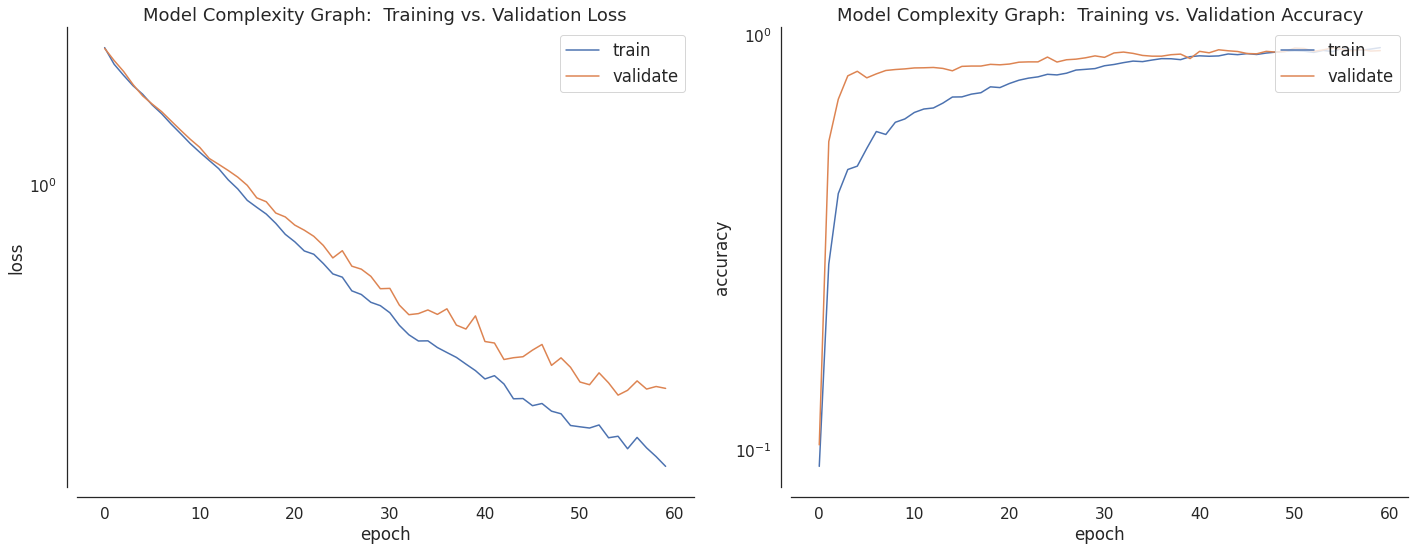

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

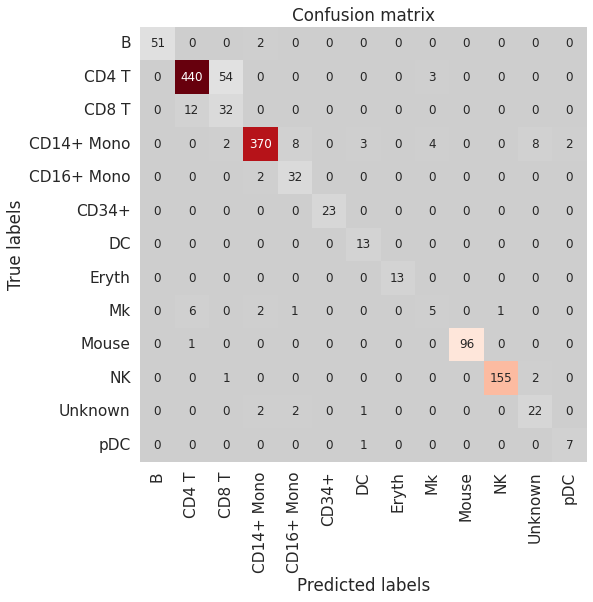

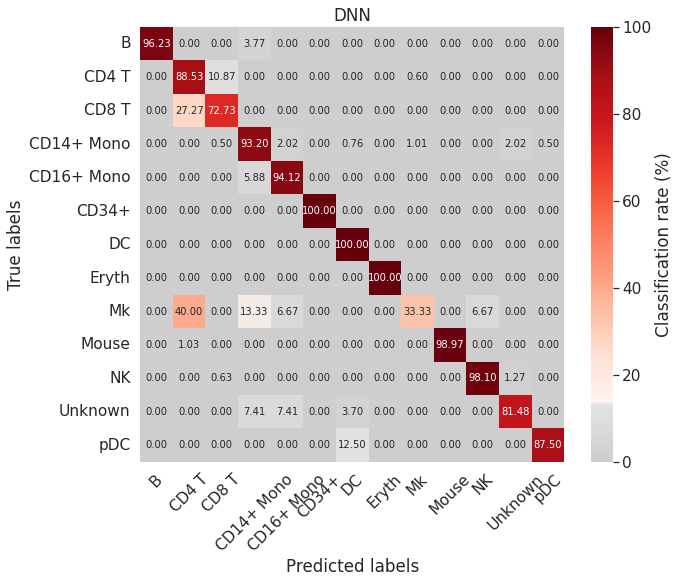

              precision    recall  f1-score   support

           B       1.00      0.96      0.98        53
       CD4 T       0.96      0.89      0.92       497
       CD8 T       0.36      0.73      0.48        44
  CD14+ Mono       0.98      0.93      0.95       397
  CD16+ Mono       0.74      0.94      0.83        34
       CD34+       1.00      1.00      1.00        23
          DC       0.72      1.00      0.84        13
       Eryth       1.00      1.00      1.00        13
          Mk       0.42      0.33      0.37        15
       Mouse       1.00      0.99      0.99        97
          NK       0.99      0.98      0.99       158
     Unknown       0.69      0.81      0.75        27
         pDC       0.78      0.88      0.82         8

    accuracy                           0.91      1379
   macro avg       0.82      0.88      0.84      1379
weighted avg       0.94      0.91      0.92      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2659 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


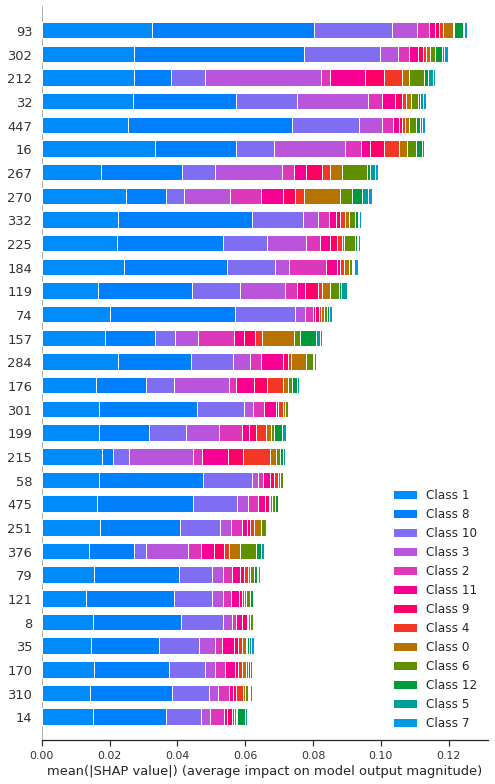

 * Initialising ...
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 32)                16032     
_________________________________________________________________
batch_normalization_56 (Batc (None, 32)                128       
_________________________________________________________________
activation_56 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16)                64        
_________________________________________________________________
activation_57 (Activation)   (Non

56/56 [==============================] - 0s 3ms/step - loss: 0.7690 - accuracy: 0.7575 - auc: 0.9806 - precision: 0.9540 - recall: 0.3159 - val_loss: 0.8484 - val_accuracy: 0.8325 - val_auc: 0.9905 - val_precision: 0.9747 - val_recall: 0.3626

Epoch 00019: val_loss improved from 0.87292 to 0.84839, saving model to weights/best_model_annotation.h5
Epoch 20/100
56/56 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.7515 - auc: 0.9806 - precision: 0.9555 - recall: 0.3464 - val_loss: 0.7887 - val_accuracy: 0.8615 - val_auc: 0.9917 - val_precision: 0.9599 - val_recall: 0.4170

Epoch 00020: val_loss improved from 0.84839 to 0.78874, saving model to weights/best_model_annotation.h5
Epoch 21/100
56/56 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.7693 - auc: 0.9823 - precision: 0.9367 - recall: 0.3703 - val_loss: 0.7768 - val_accuracy: 0.8484 - val_auc: 0.9911 - val_precision: 0.9461 - val_recall: 0.4329

Epoch 00021: val_loss improved f


Epoch 00042: val_loss did not improve from 0.34230
Epoch 43/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2841 - accuracy: 0.8861 - auc: 0.9953 - precision: 0.9417 - recall: 0.7992 - val_loss: 0.3344 - val_accuracy: 0.9130 - val_auc: 0.9964 - val_precision: 0.9282 - val_recall: 0.8811

Epoch 00043: val_loss improved from 0.34230 to 0.33444, saving model to weights/best_model_annotation.h5
Epoch 44/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2660 - accuracy: 0.8954 - auc: 0.9960 - precision: 0.9374 - recall: 0.8179 - val_loss: 0.3171 - val_accuracy: 0.9123 - val_auc: 0.9966 - val_precision: 0.9339 - val_recall: 0.8920

Epoch 00044: val_loss improved from 0.33444 to 0.31714, saving model to weights/best_model_annotation.h5
Epoch 45/100
56/56 [==============================] - 0s 3ms/step - loss: 0.2555 - accuracy: 0.9021 - auc: 0.9962 - precision: 0.9445 - recall: 0.8304 - val_loss: 0.3521 - val_accuracy: 0.8941 - val_auc: 0.9955 - val_precisi


Epoch 00067: val_loss did not improve from 0.24963
Epoch 68/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.9305 - auc: 0.9980 - precision: 0.9504 - recall: 0.9035 - val_loss: 0.2642 - val_accuracy: 0.9144 - val_auc: 0.9959 - val_precision: 0.9251 - val_recall: 0.9043

Epoch 00068: val_loss did not improve from 0.24963
Epoch 69/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.9300 - auc: 0.9979 - precision: 0.9480 - recall: 0.9021 - val_loss: 0.2537 - val_accuracy: 0.9195 - val_auc: 0.9961 - val_precision: 0.9270 - val_recall: 0.9123

Epoch 00069: val_loss did not improve from 0.24963
Epoch 70/100
56/56 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9331 - auc: 0.9981 - precision: 0.9528 - recall: 0.9046 - val_loss: 0.2478 - val_accuracy: 0.9217 - val_auc: 0.9963 - val_precision: 0.9278 - val_recall: 0.9130

Epoch 00070: val_loss improved from 0.24963 to 0.24785, saving model to wei

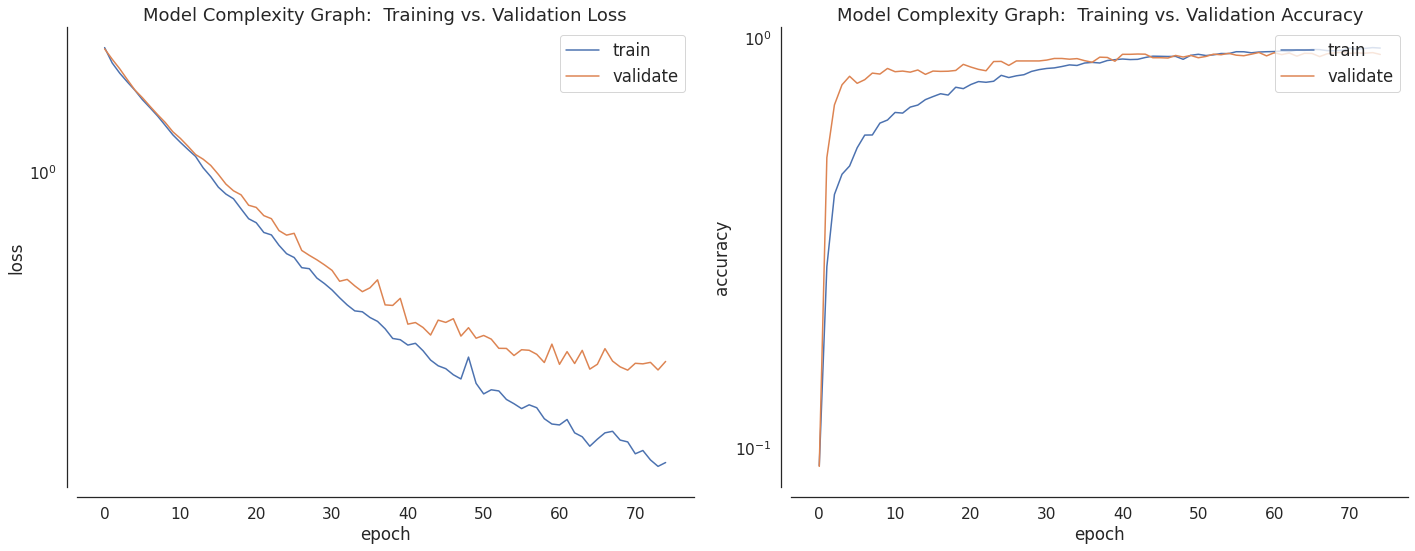

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

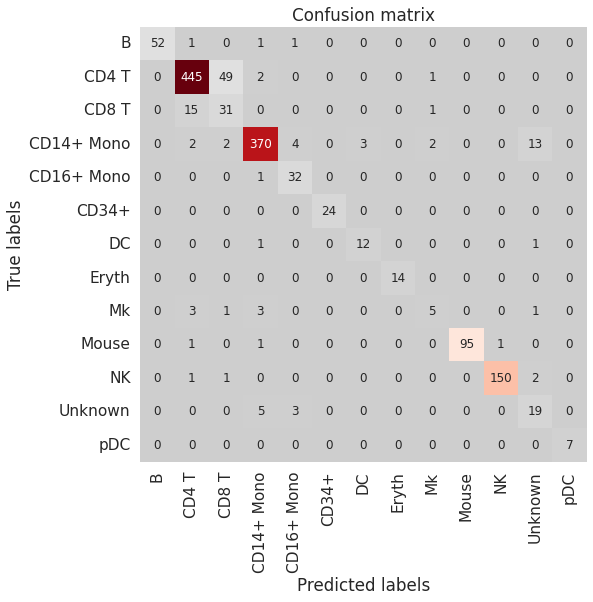

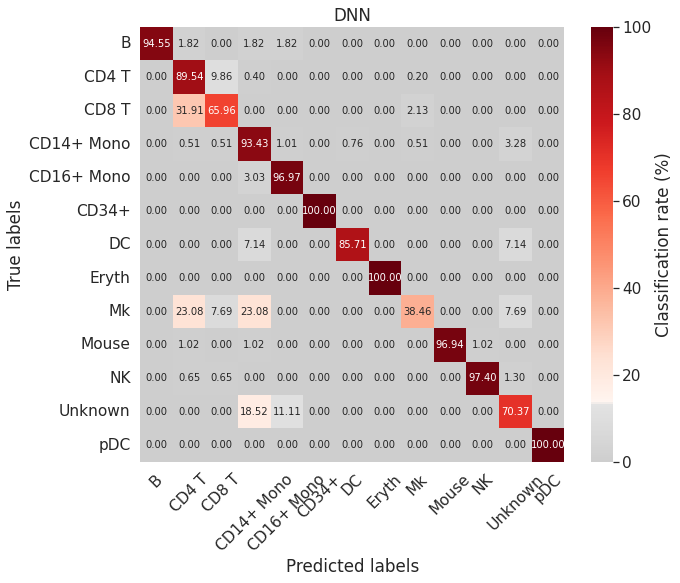

              precision    recall  f1-score   support

           B       1.00      0.95      0.97        55
       CD4 T       0.95      0.90      0.92       497
       CD8 T       0.37      0.66      0.47        47
  CD14+ Mono       0.96      0.93      0.95       396
  CD16+ Mono       0.80      0.97      0.88        33
       CD34+       1.00      1.00      1.00        24
          DC       0.80      0.86      0.83        14
       Eryth       1.00      1.00      1.00        14
          Mk       0.56      0.38      0.45        13
       Mouse       1.00      0.97      0.98        98
          NK       0.99      0.97      0.98       154
     Unknown       0.53      0.70      0.60        27
         pDC       1.00      1.00      1.00         7

    accuracy                           0.91      1379
   macro avg       0.84      0.87      0.85      1379
weighted avg       0.93      0.91      0.92      1379

44/44 [==============================] - 0s 1ms/step - loss: 0.2478 - accuracy:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


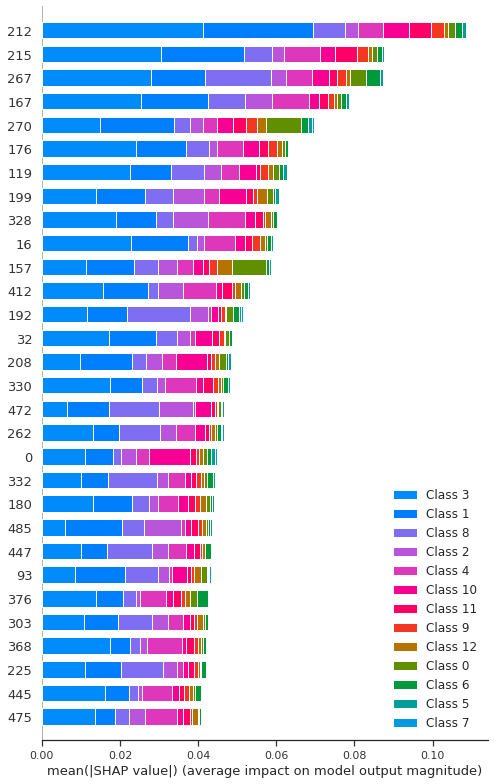

CPU times: user 13min 2s, sys: 26.1 s, total: 13min 28s
Wall time: 6min 26s


In [19]:
%%time
k = 50
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = citeseq_adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = citeseq_adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [20]:
# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
np.random.seed(possible_seeds[seed_index])
seed_index += 1

## Train RankCorr

In [21]:
lamb_range = [0.5, 1.5, 3, 7, 21.9]
lamb_i = 0

In [22]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = lamb_range[lamb_i]
    lamb_i = lamb_i + 1

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        print(lamb)
        print(len(rankcorr_markers))
        print(k)
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        #print("Excess Length of markers")
        #print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_k_{}.png'.format(k), markers = rankcorr_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [23]:
k = 50
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 3.2# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        #print("Excess Length of markers")
        #print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(citeseq_adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

## Train L1 VAE

In [24]:
feature_std = torch.tensor(X).std(dim = 0)
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'l1_vae_markers_k_{}.npy'.format(k), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_k_{}.png'.format(k), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 63.52it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 64.28i

In [25]:
feature_std = torch.tensor(X).std(dim = 0)
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 64.05it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 63.55it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and 

## Train Global Gate

In [26]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_k_{}.png'.format(k), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 54.11it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 46.63i

In [27]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.37it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 36.83i

## Train MarkerMap Unsupervised

In [28]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    marker_map_unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = marker_map_unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), marker_map_unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_k_{}.png'.format(k), markers = marker_map_unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 50.89it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 43.12i

In [29]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.58it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.78i

## MarkerMap Supervised

In [30]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_k_{}.ckpt'.format(k)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_k_{}.png'.format(k), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 54.03it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 45.40it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.17it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

In [31]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 36.46it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 36.86it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 37.17it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## Train MarkerMap Mixed Supervision

In [32]:
for tryy in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_k_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_k_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 33.54it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 33.81it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:03<00:00, 32.16it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

In [33]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 33.47it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 33.66it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 34.00it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
`trainer.tune(train

## Concrete VAE

In [34]:
for k in k_range:
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_k_{}.ckpt'.format(k)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_k_{}.png'.format(k), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 56.38it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 58.05i

In [35]:
k = 50
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 60.53it/s]
Checkpoint directory /home/admin/ThisComp/ggpkg/MarkerMap/notebooks/checkpoints exists and is not empty.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 59.13i

## LassoNet

In [36]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
from functools import partial
from lassonet import plot_path

In [38]:
k = 50
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

In [39]:
for k in k_range:
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), results)
    np.save(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), (train_indices, val_indices, test_indices))
    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_k_{}.png'.format(k), markers = lasso_net_markers)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Get Model Metrics from KNNs Classifiers


In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

In [42]:
def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [43]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [44]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [45]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

In [46]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

In [47]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

In [48]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [49]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')

In [50]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')

In [51]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [52]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [53]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

### Generate the same metrics using the various K ranges instead

In [54]:
# for looking at things that did one trial
def batch_generate_metrics_from_saved_files_limited(X, y, format_folds_path, format_markers_path, format_save_path):
    for k in k_range:
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(k), format_markers_path.format(k), classifier_model, format_save_path.format(k))
    return

In [55]:
batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_k_{}.npy',
                                  model_save_path+'l1_vae_markers_k_{}.npy',
                                  model_save_path+'l1_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_k_{}.npy',
                                  model_save_path+'smash_rf_markers_k_{}.npy',
                                  model_save_path+'smash_rf_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_k_{}.npy',
                                  model_save_path+'smash_markers_k_{}.npy',
                                  model_save_path+'smash_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_k_{}.npy',
                                  model_save_path+'rankcorr_markers_k_{}.npy',
                                  model_save_path+'rankcorr_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_k_{}.npy',
                                  model_save_path+'globalgate_vae_markers_k_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_k_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_k_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_k_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_k_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_k_{}.npy')


batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_k_{}.npy',
                                  model_save_path+'concrete_vae_markers_k_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_k_{}.npy')

batch_generate_metrics_from_saved_files_limited(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_k_{}.npy',
                                  model_save_path+'lasso_net_markers_k_{}.npy',
                                  model_save_path+'lasso_net_knn_results_k_{}.npy')

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

# Results and Visualizations

In [56]:
k = 50

## Accuracies and F1

In [57]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [58]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [59]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.076624          0.899738   
L1 VAE                                     0.118794          0.848660   
Smash RF                                   0.066763          0.917128   
SMaSH DNN                                  0.071230          0.910883   
RankCorr                                   0.065139          0.918060   
Global Gate VAE                            0.131613          0.833690   
MarkerMap Unsupervised                     0.084919          0.892602   
MarkerMap Supervised                       0.061833          0.924168   
MarkerMap Mixed Supervision                0.064907          0.919449   
Concrete VAE                               0.129582          0.834574   
LassoNet                                   0.065603          0.918288   

                             Misclassification Standard Deviation  \
All Markers                                              0.004352   
L1 VAE                                                   0.027118   
Smash RF                                                 0.005791   
SMaSH DNN                                                0.006143   
RankCorr                                                 0.007949   
Global Gate VAE                                          0.018016   
MarkerMap Unsupervised                                   0.011260   
MarkerMap Supervised                                     0.004728   
MarkerMap Mixed Supervision                              0.003296   
Concrete VAE                                             0.014718   
LassoNet                                                 0.003561   

                             Weighted F1 Standard Deviation  
All Markers                                        0.005241  
L1 VAE                                             0.035671  
Smash RF                                           0.007161  
SMaSH DNN                                          0.008035  
RankCorr                                           0.010503  
Global Gate VAE                                    0.023087  
MarkerMap Unsupervised                             0.013844  
MarkerMap Supervised                               0.006857  
MarkerMap Mixed Supervision                        0.004426  
Concrete VAE                                       0.020087  
LassoNet                                           0.004984

In [60]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [61]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.096984          0.898500   
L1 VAE                                     0.164153          0.811630   
Smash RF                                   0.068852          0.918941   
SMaSH DNN                                  0.078190          0.909340   
RankCorr                                   0.072506          0.914987   
Global Gate VAE                            0.189037          0.785851   
MarkerMap Unsupervised                     0.100290          0.888140   
MarkerMap Supervised                       0.062297          0.929230   
MarkerMap Mixed Supervision                0.068852          0.920007   
Concrete VAE                               0.179640          0.797224   
LassoNet                                   0.064327          0.924896   

                             Misclassification Standard Deviation  \
All Markers                                              0.008078   
L1 VAE                                                   0.046672   
Smash RF                                                 0.006269   
SMaSH DNN                                                0.007396   
RankCorr                                                 0.004990   
Global Gate VAE                                          0.020229   
MarkerMap Unsupervised                                   0.014086   
MarkerMap Supervised                                     0.005150   
MarkerMap Mixed Supervision                              0.005684   
Concrete VAE                                             0.025688   
LassoNet                                                 0.004459   

                             Weighted F1 Standard Deviation  
All Markers                                        0.007225  
L1 VAE                                             0.055522  
Smash RF                                           0.006400  
SMaSH DNN                                          0.009297  
RankCorr                                           0.006592  
Global Gate VAE                                    0.024359  
MarkerMap Unsupervised                             0.013967  
MarkerMap Supervised                               0.006244  
MarkerMap Mixed Supervision                        0.005807  
Concrete VAE                                       0.029446  
LassoNet                                           0.005799

## Confusion Matrices

k = 50

### All Markers

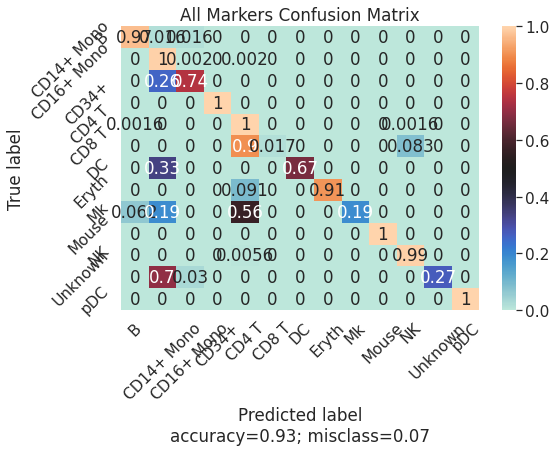

In [62]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [63]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

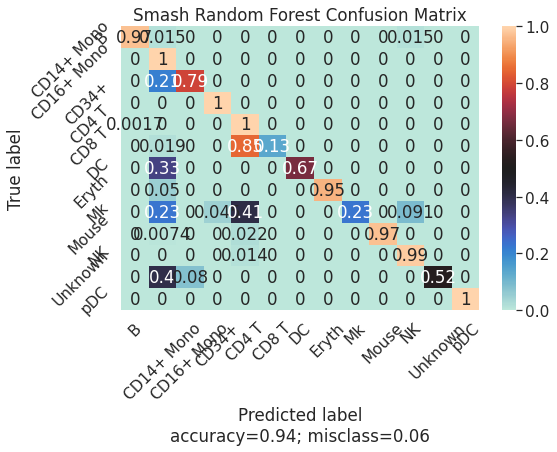

In [64]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

In [65]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)

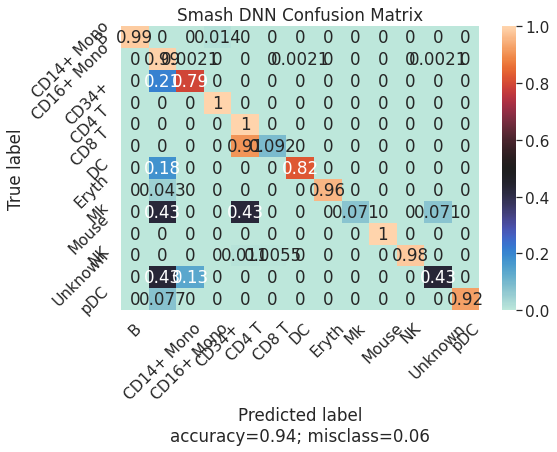

In [66]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

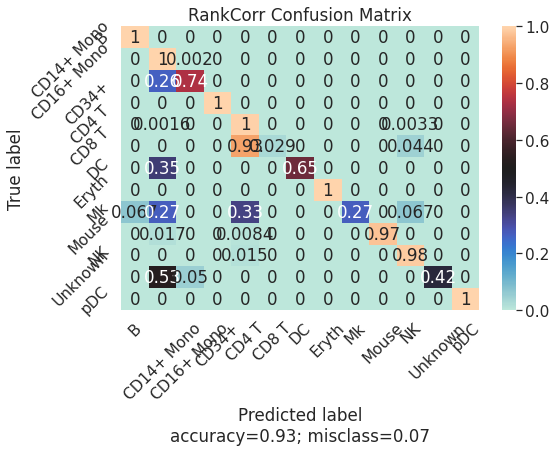

In [67]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

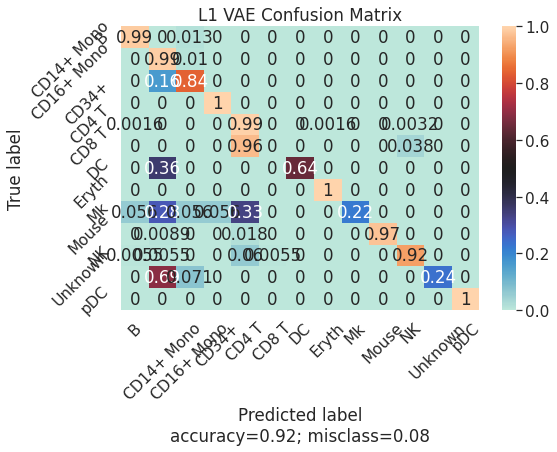

In [68]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

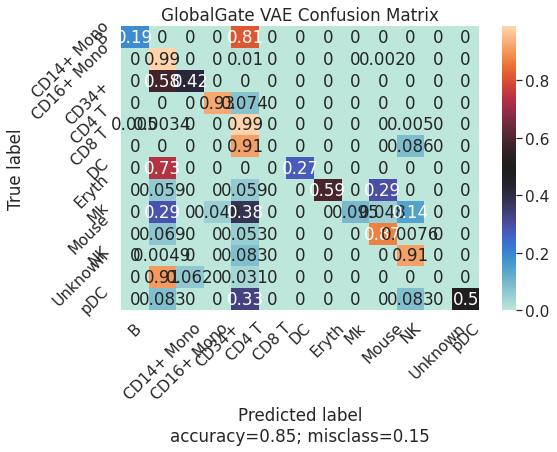

In [69]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### Running MarkerMap Unsupervised

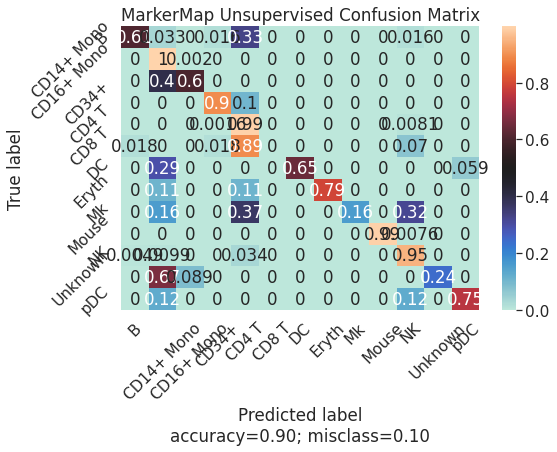

In [70]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### Running MarkerMap Supervised


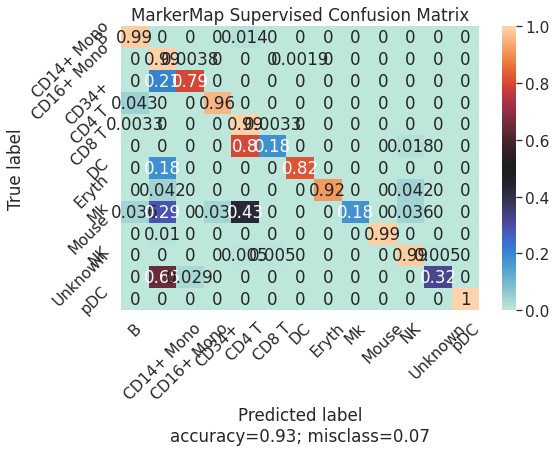

In [71]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

### MarkerMap Mixed Supervision

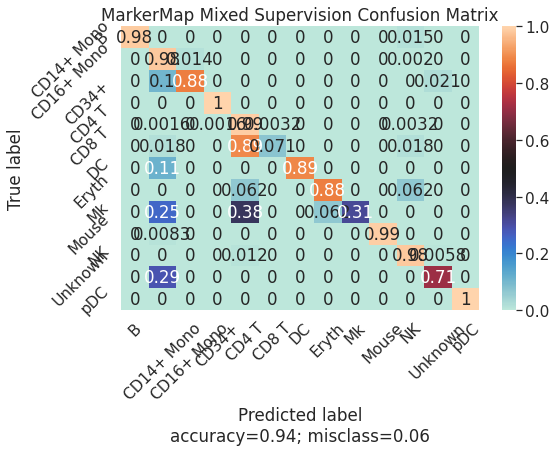

In [72]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

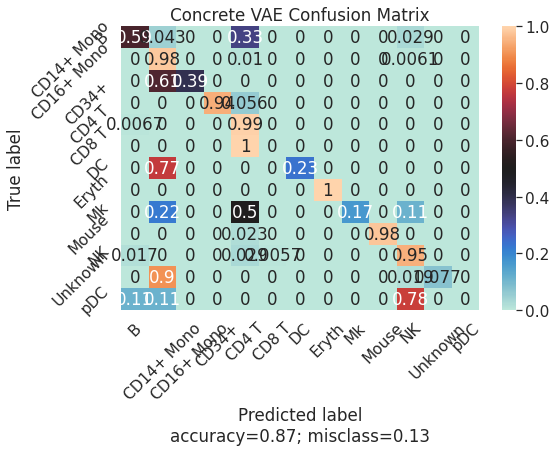

In [73]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

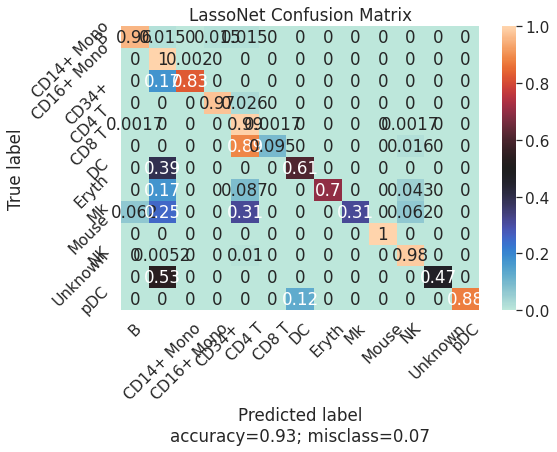

In [74]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')

## Visualizing k on weighted f1

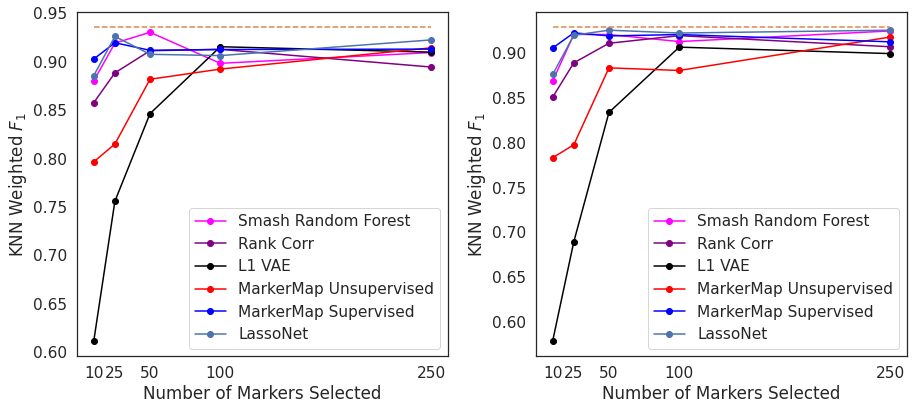

In [75]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k.pdf')

#### Include everything

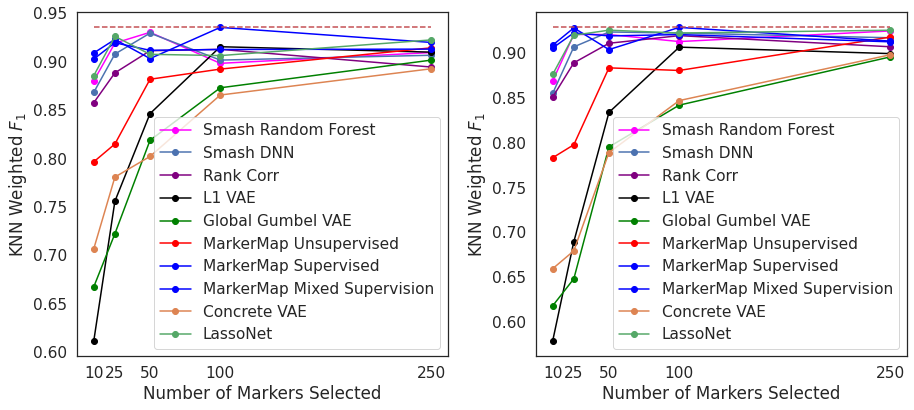

In [76]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))

#rf
smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel(r"KNN Weighted $F_1$")
axs[0].legend()

#knn

smash_rf_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(rep['weighted avg']['f1-score'])


smash_dnn_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(rep['weighted avg']['f1-score'])

rank_corr_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(rep['weighted avg']['f1-score'])

l1_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(rep['weighted avg']['f1-score'])

globalgate_vae_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(rep['weighted avg']['f1-score'])

marker_map_unsupervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(rep['weighted avg']['f1-score'])

marker_map_supervised_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(rep['weighted avg']['f1-score'])


marker_map_mixed_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(rep['weighted avg']['f1-score'])

concrete_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(rep['weighted avg']['f1-score'])

lasso_net_scores = []
for k_i in k_range:
    _, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(rep['weighted avg']['f1-score'])


scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
max_point = max([max(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, max_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel(r"KNN Weighted $F_1$")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_weighted_f1_vs_k_all.pdf')

### Do Misclassification now

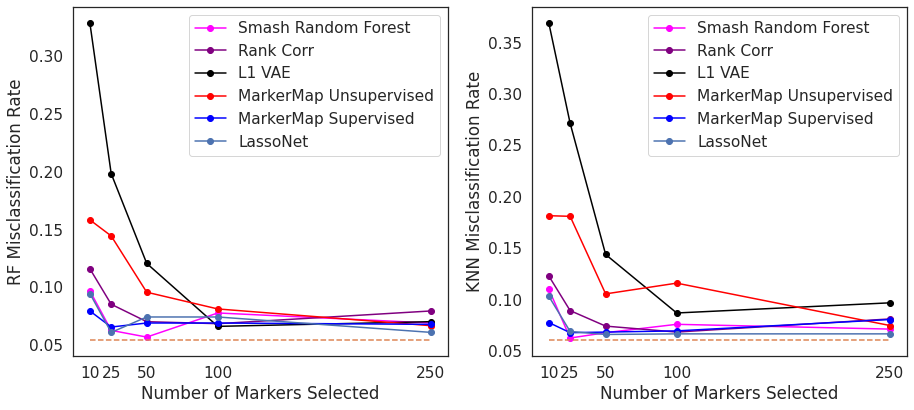

In [77]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
#plt.plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
#plt.plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
#plt.plot(k_range, marker_map_mixed_scores, label = 'RunningState VAE+Classifier', color = 'blue', marker = 'o')
#plt.plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o)
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k.pdf')

##### Include everything

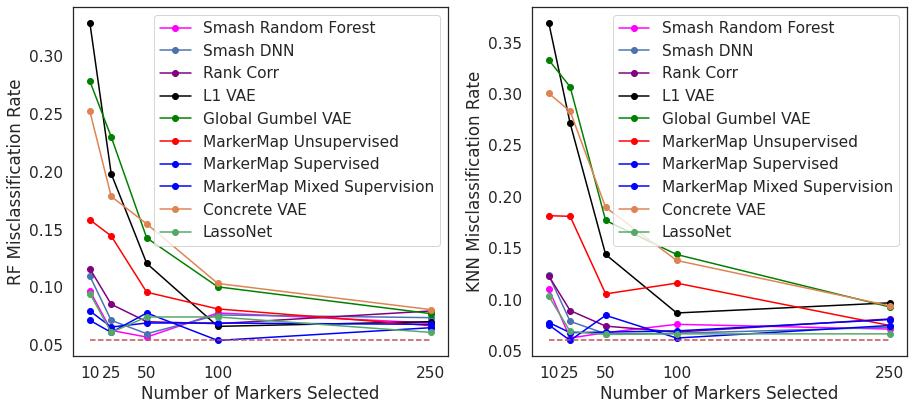

In [78]:
fig, axs = plt.subplots(1, 2, figsize = (13, 6))
# random forest
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)
    
scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[0].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[0].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[0].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[0].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[0].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[0].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[0].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[0].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[0].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[0].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[0].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[0].set_xlabel("Number of Markers Selected")
axs[0].set_xticks(k_range)
axs[0].set_ylabel("RF Misclassification Rate")
axs[0].legend()

# knn
smash_rf_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_rf_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_rf_scores.append(m)

smash_dnn_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'smash_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    smash_dnn_scores.append(m)

rank_corr_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'rankcorr_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    rank_corr_scores.append(m)

l1_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'l1_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    l1_vae_scores.append(m)

globalgate_vae_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'globalgate_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    globalgate_vae_scores.append(m)

marker_map_unsupervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_unsupervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_unsupervised_scores.append(m)

marker_map_supervised_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_supervised_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_supervised_scores.append(m)

marker_map_mixed_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'marker_map_mixed_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    marker_map_mixed_scores.append(m)

concrete_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'concrete_vae_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    concrete_scores.append(m)

lasso_net_scores = []
for k_i in k_range:
    m, rep, _ = np.load(model_save_path + 'lasso_net_knn_results_k_{}.npy'.format(k_i), allow_pickle = True)
    lasso_net_scores.append(m)

scores = [smash_rf_scores, smash_dnn_scores, rank_corr_scores, l1_vae_scores, globalgate_vae_scores, marker_map_unsupervised_scores, marker_map_supervised_scores, 
          marker_map_mixed_scores, concrete_scores, lasso_net_scores]
min_point = min([min(score) for score in scores])
axs[1].plot(k_range, smash_rf_scores, label = 'Smash Random Forest', color = 'magenta', marker = 'o')
axs[1].plot(k_range, smash_dnn_scores, label = 'Smash DNN', marker = 'o')
axs[1].plot(k_range, rank_corr_scores, label = 'Rank Corr', color = 'purple', marker = 'o')
axs[1].plot(k_range, l1_vae_scores, label = 'L1 VAE', color = 'black', marker = 'o')
axs[1].plot(k_range, globalgate_vae_scores, label = 'Global Gumbel VAE', color = 'green', marker = 'o')
axs[1].plot(k_range, marker_map_unsupervised_scores, label = 'MarkerMap Unsupervised', color = 'red', marker = 'o')
axs[1].plot(k_range, marker_map_supervised_scores, label = 'MarkerMap Supervised', color = 'blue', marker = 'o')
axs[1].plot(k_range, marker_map_mixed_scores, label = 'MarkerMap Mixed Supervision', color = 'blue', marker = 'o')
axs[1].plot(k_range, concrete_scores, label = 'Concrete VAE', marker = 'o')
axs[1].plot(k_range, lasso_net_scores, label = 'LassoNet', marker = 'o')
axs[1].plot(k_range, min_point * np.ones(len(k_range)), linestyle = '--')
axs[1].set_xlabel("Number of Markers Selected")
axs[1].set_xticks(k_range)
axs[1].set_ylabel("KNN Misclassification Rate")
axs[1].legend()

plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_misclassification_vs_k_all.pdf')

## Visualize Marker Selection

### Smash RF

In [79]:
smash_rf_markers = {}
smash_rf_f1 = {}

In [80]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_rf_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_rf_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_rf_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_rf_markers[k] = marker_data
    smash_rf_f1[k] = weighted_f1_score

### Smash DNN

In [81]:
smash_dnn_markers = {}
smash_dnn_f1 = {}

In [82]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_dnn_markers[k] = marker_data
    smash_dnn_f1[k] = weighted_f1_score

### RankCorr

In [83]:
rankcorr_markers ={}
rankcorr_f1 = {}

In [84]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/rankcorr_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'rankcorr_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'rankcorr_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    rankcorr_markers[k] = marker_data
    rankcorr_f1[k] = weighted_f1_score

### L1 VAE

In [85]:
l1_vae_markers = {}
l1_vae_f1 = {}

In [86]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/l1_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    X_train = X[train_indices, :]
    feature_std = np.apply_along_axis(np.std, 0, X_train)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'l1_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']

    model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_k_{}.ckpt'.format(k))
    with torch.no_grad():
        markers = model.markers(feature_std, k)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    l1_vae_markers[k] = marker_data
    l1_vae_f1[k] = weighted_f1_score

### GlobalGate VAE

In [87]:
globalgate_vae_markers = {}
globalgate_vae_f1 = {}

In [88]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/globalgate_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'globalgate_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'globalgate_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    globalgate_vae_markers[k] = marker_data
    globalgate_vae_f1[k] = weighted_f1_score

### MarkerMap Unsupervised

In [89]:
marker_map_unsupervised_markers = {}
marker_map_unsupervised_f1 = {}

In [90]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_unsupervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_unsupervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_unsupervised_markers[k] = marker_data
    marker_map_unsupervised_f1[k] = weighted_f1_score

### RunningState Classifier

In [91]:
marker_map_supervised_markers = {}
marker_map_supervised_f1 = {}

In [92]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_supervised_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_supervised_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_supervised_markers[k] = marker_data
    marker_map_supervised_f1[k] = weighted_f1_score

### MarkerMap Mixed Supervision

In [93]:
marker_map_mixed_markers = {}
marker_map_mixed_f1 = {}

In [94]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_mixed_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'marker_map_mixed_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    marker_map_mixed_markers[k] = marker_data
    marker_map_mixed_f1[k] = weighted_f1_score

### Concrete VAE

In [95]:
concrete_vae_markers = {}
concrete_vae_f1 = {}

In [96]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/concrete_vae_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'concrete_vae_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'concrete_vae_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    concrete_vae_markers[k] = marker_data
    concrete_vae_f1[k] = weighted_f1_score

## LassoNet

In [97]:
lasso_net_markers = {}
lasso_net_f1 = {}

In [98]:
for k in k_range:
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/lasso_net_indices_k_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'lasso_net_results_k_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'lasso_net_markers_k_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    lasso_net_markers[k] = marker_data
    lasso_net_f1[k] = weighted_f1_score

### The Actual Subplot

In [99]:
def plot_row(ax, name, k_range, markers, f1):
    assert len(ax) == len(k_range)
    for i in range(len(k_range)):
        col = ax[i]
        k = k_range[i]
        if i == 0:
            col.set_ylabel("{}".format(name))
        col.set_ylim([0, 1.2])
        col.set_yticks([0, 1.0])
        col.set_title("{} Markers(Weighted F1 {:.3g})".format(k, f1[k]))        
        col.bar(range(X.shape[1]), markers[k], width = 10)
    return

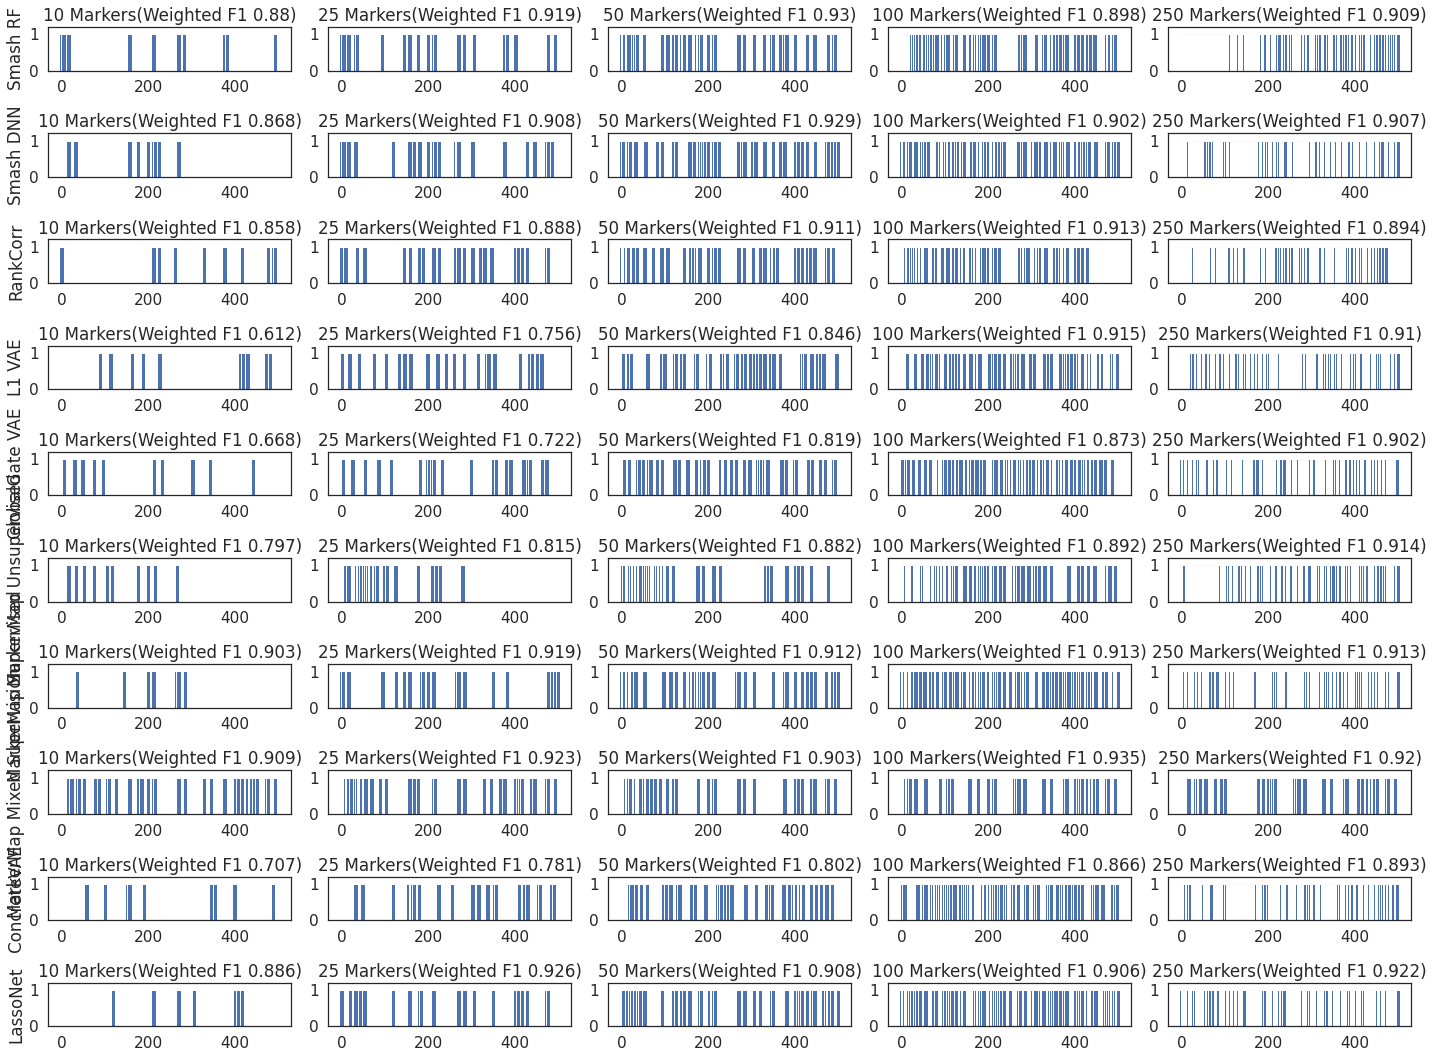

In [100]:
fig, axs = plt.subplots(nrows=10, ncols = len(k_range), figsize = (20, 15))

plot_row(axs[0], 'Smash RF', k_range, smash_rf_markers, smash_rf_f1)
plot_row(axs[1], 'Smash DNN', k_range, smash_dnn_markers, smash_dnn_f1)
plot_row(axs[2], 'RankCorr', k_range, rankcorr_markers, rankcorr_f1)
plot_row(axs[3], 'L1 VAE', k_range, l1_vae_markers, l1_vae_f1)
plot_row(axs[4], 'GlobalGate VAE', k_range, globalgate_vae_markers, globalgate_vae_f1)
plot_row(axs[5], 'MarkerMap Unsupervised', k_range, marker_map_unsupervised_markers, marker_map_unsupervised_f1)
plot_row(axs[6], 'MarkerMap Supervised', k_range, marker_map_supervised_markers, marker_map_supervised_f1)
plot_row(axs[7], 'MarkerMap Mixed Supervision', k_range, marker_map_mixed_markers, marker_map_mixed_f1)
plot_row(axs[8], 'ConcreteVAE', k_range, concrete_vae_markers, concrete_vae_f1)
plot_row(axs[9], 'LassoNet', k_range, lasso_net_markers, lasso_net_f1)


plt.tight_layout()
plt.savefig(viz_save_path + 'CiteSeq_SelectedMarkers_All_Methods_ks.png')
plt.show()

In [101]:
plt.close('all')